# Comprehensive Deep EDA on Filtered Churn Dataset
## Customer Churn Prediction with Survival Analysis

This notebook performs an extensive exploratory data analysis on the filtered churn dataset including:
- Statistical analysis and distributions
- Churn pattern analysis
- Advanced correlations
- Customer segmentation
- Cohort analysis
- Survival analysis insights
- Feature engineering opportunities

In [86]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, kstest
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Initial Inspection

In [87]:
# Load the filtered dataset
df = pd.read_csv('../dataset/filtered_churn_data.csv')
df = pd.read_csv('/Users/pituchai/Churn/Customer-Churn-Prediction-with-Survival-Analysis---Retention-Strategy-Optimization/dataset/thai_customer_churn_dataset.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nTotal Customers: {len(df):,}")
print(f"Total Features: {df.shape[1]}")
print(f"\nChurned Customers: {df['churned'].sum():,} ({df['churned'].mean()*100:.2f}%)")
print(f"Active Customers: {(1-df['churned']).sum():,} ({(1-df['churned'].mean())*100:.2f}%)")

Dataset Shape: (100000, 54)

Total Customers: 100,000
Total Features: 54

Churned Customers: 31,369 (31.37%)
Active Customers: 68,631 (68.63%)


In [88]:
# Display basic info
print("\n=== Dataset Info ===")
df.info()


=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   customer_id                  100000 non-null  object 
 1   full_name_thai               100000 non-null  object 
 2   gender                       100000 non-null  object 
 3   age                          100000 non-null  int64  
 4   senior_citizen               100000 non-null  int64  
 5   partner                      100000 non-null  object 
 6   dependents                   100000 non-null  int64  
 7   province                     100000 non-null  object 
 8   postcode                     100000 non-null  int64  
 9   region                       100000 non-null  object 
 10  account_created_date         100000 non-null  object 
 11  tenure_months                100000 non-null  int64  
 12  contract_type                100000 n

In [89]:
# Check for missing values
missing_data = df.isnull().sum()
missing_pct = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)

print("\n=== Missing Values Summary ===")
print(missing_df[missing_df['Missing_Count'] > 0])


=== Missing Values Summary ===
                        Missing_Count  Missing_Percentage
competitor_switched_to          91933              91.933
churn_reason                    68631              68.631
churn_date                      68631              68.631
internet_service                12973              12.973


## 2. Statistical Analysis and Distributions

In [90]:
# Comprehensive statistical summary
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('customer_id') if 'customer_id' in numerical_cols else None

stats_summary = df[numerical_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T
stats_summary['skewness'] = df[numerical_cols].skew()
stats_summary['kurtosis'] = df[numerical_cols].kurtosis()
stats_summary['cv'] = stats_summary['std'] / stats_summary['mean']  # Coefficient of variation

print("\n=== Extended Statistical Summary ===")
print(stats_summary.round(2))


=== Extended Statistical Summary ===
                                count      mean       std       min        1%  \
age                          100000.0     38.05     13.02     18.00     18.00   
senior_citizen               100000.0      0.06      0.24      0.00      0.00   
dependents                   100000.0      1.45      1.16      0.00      0.00   
postcode                     100000.0  43310.54  26488.91  10100.00  10165.00   
tenure_months                100000.0     28.43     16.70      0.00      0.00   
multiple_lines               100000.0      0.90      0.89      0.00      0.00   
monthly_charges_thb          100000.0    988.99    433.89    199.00    199.00   
total_charges_thb            100000.0  28143.99  21913.49      0.00      0.00   
price_increase_6months_thb   100000.0     32.31     61.22      0.00      0.00   
discount_amount_thb          100000.0     86.57    142.06      0.00      0.00   
payment_delay_days           100000.0      2.52      2.99      0.00    

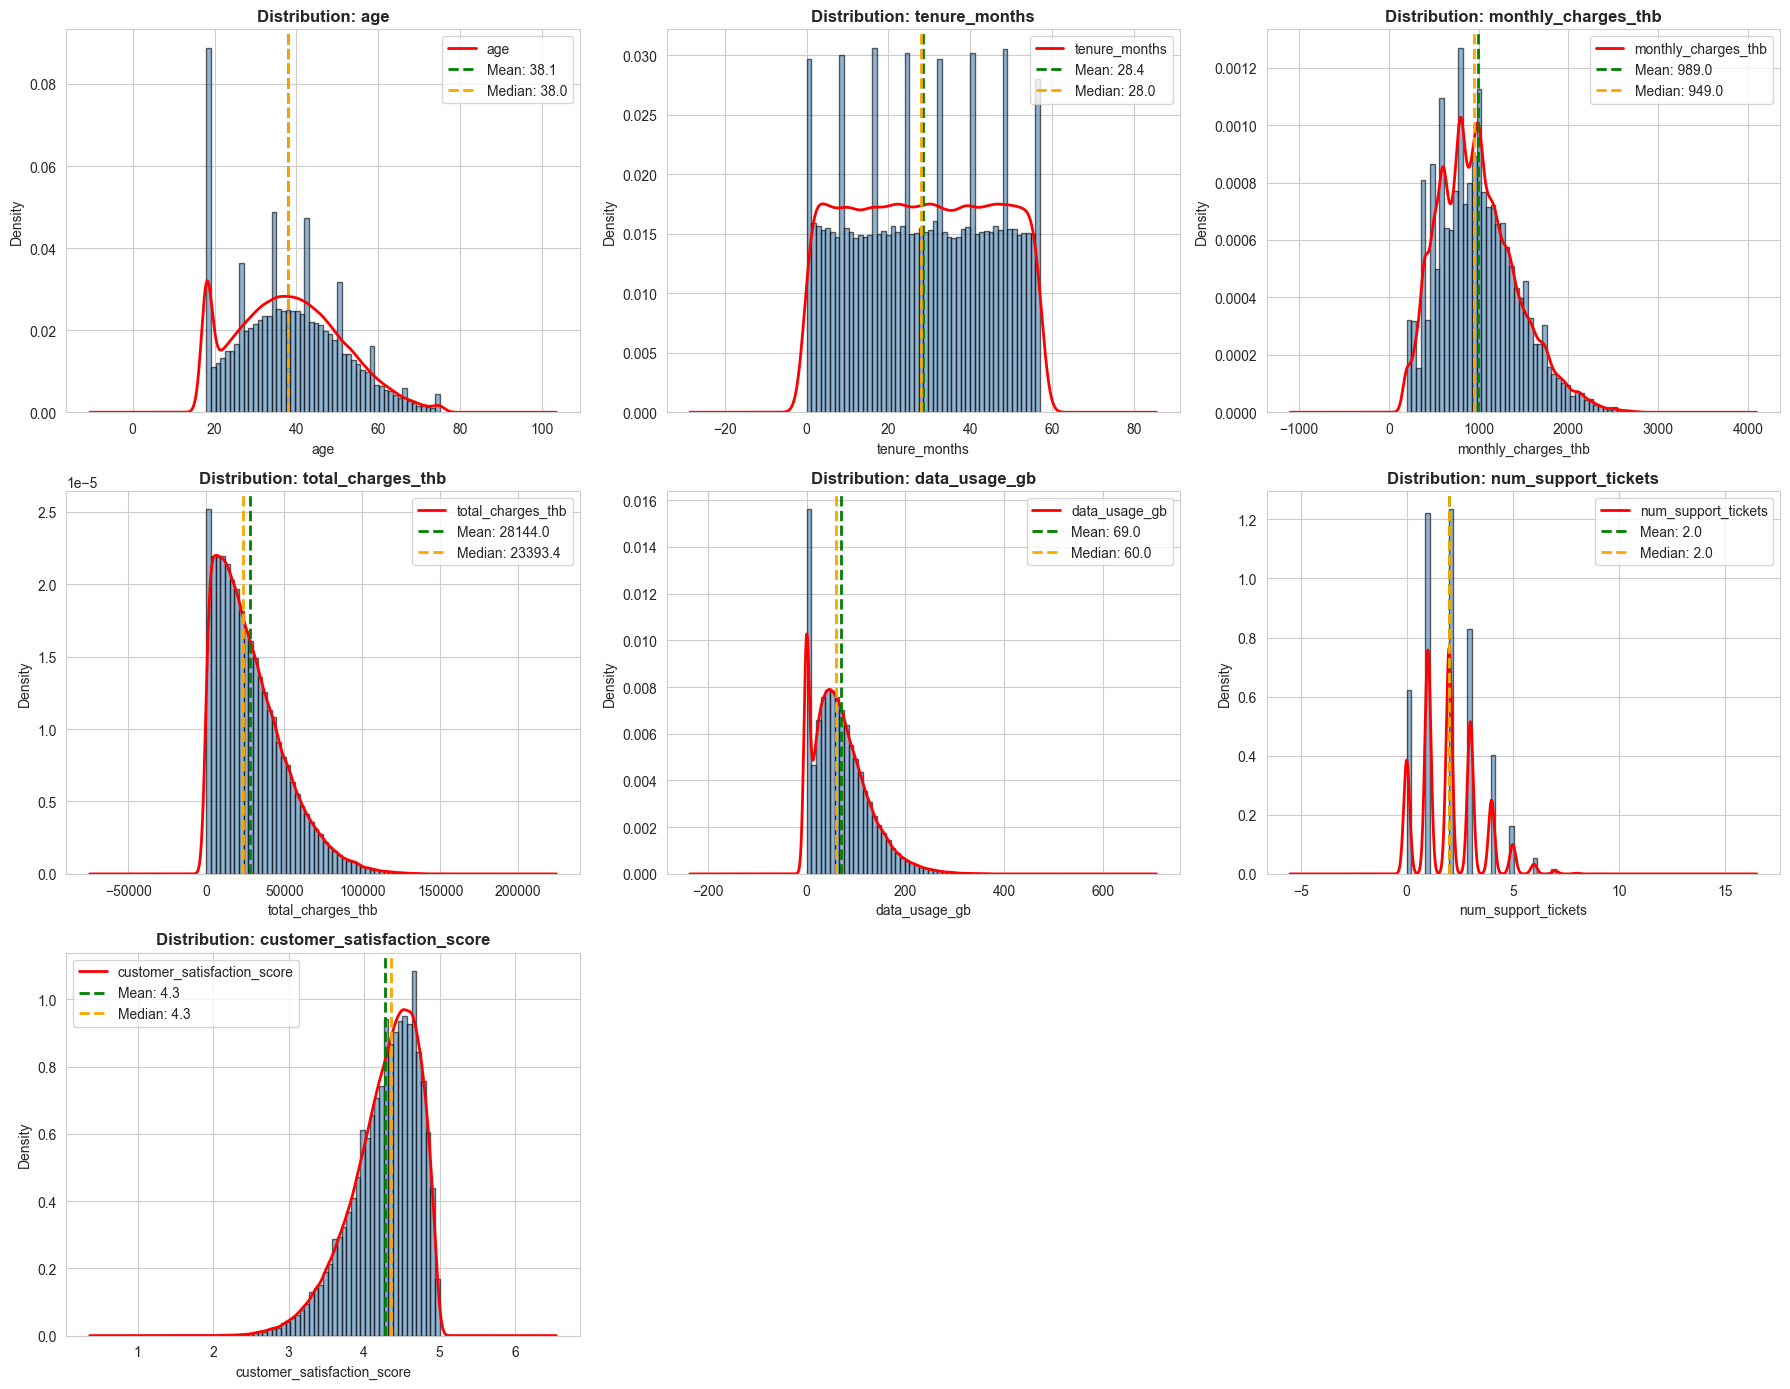


✓ Distribution analysis completed


In [91]:
# Distribution analysis for key numerical features
key_features = ['age', 'tenure_months', 'monthly_charges_thb', 'total_charges_thb', 
                'data_usage_gb', 'num_support_tickets', 'customer_satisfaction_score']

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.ravel()

for idx, col in enumerate(key_features):
    if idx < len(axes):
        # Histogram with KDE
        axes[idx].hist(df[col].dropna(), bins=50, alpha=0.6, color='steelblue', edgecolor='black', density=True)
        df[col].dropna().plot(kind='kde', ax=axes[idx], color='red', linewidth=2)
        axes[idx].set_title(f'Distribution: {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Density')
        
        # Add statistics
        mean_val = df[col].mean()
        median_val = df[col].median()
        axes[idx].axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
        axes[idx].axvline(median_val, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
        axes[idx].legend()

# Remove empty subplots
for idx in range(len(key_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

print("\n✓ Distribution analysis completed")

## 3. Churn Pattern Analysis

In [92]:
# Churn rate by different categories
categorical_features = ['gender', 'senior_citizen', 'partner', 'dependents', 'contract_type', 
                        'payment_method', 'internet_service', 'paperless_billing', 'region']

churn_analysis = {}
for feature in categorical_features:
    if feature in df.columns:
        churn_by_cat = df.groupby(feature)['churned'].agg(['sum', 'count', 'mean']).reset_index()
        churn_by_cat.columns = [feature, 'churned_count', 'total_count', 'churn_rate']
        churn_by_cat['churn_rate_pct'] = churn_by_cat['churn_rate'] * 100
        churn_analysis[feature] = churn_by_cat.sort_values('churn_rate', ascending=False)

# Display top churn patterns
print("\n=== Churn Rate by Category ===")
for feature, data in churn_analysis.items():
    print(f"\n{feature.upper()}:")
    print(data.to_string(index=False))


=== Churn Rate by Category ===

GENDER:
gender  churned_count  total_count  churn_rate  churn_rate_pct
  Male          15386        48776    0.315442       31.544202
Female          15983        51224    0.312022       31.202171

SENIOR_CITIZEN:
 senior_citizen  churned_count  total_count  churn_rate  churn_rate_pct
              1           1906         5914    0.322286       32.228610
              0          29463        94086    0.313150       31.314967

PARTNER:
partner  churned_count  total_count  churn_rate  churn_rate_pct
    Yes          17268        54986    0.314044       31.404357
     No          14101        45014    0.313258       31.325810

DEPENDENTS:
 dependents  churned_count  total_count  churn_rate  churn_rate_pct
          0           7906        25032    0.315836       31.583573
          2           7870        24974    0.315128       31.512773
          1           9423        29950    0.314624       31.462437
          3           4685        15012    0.31208

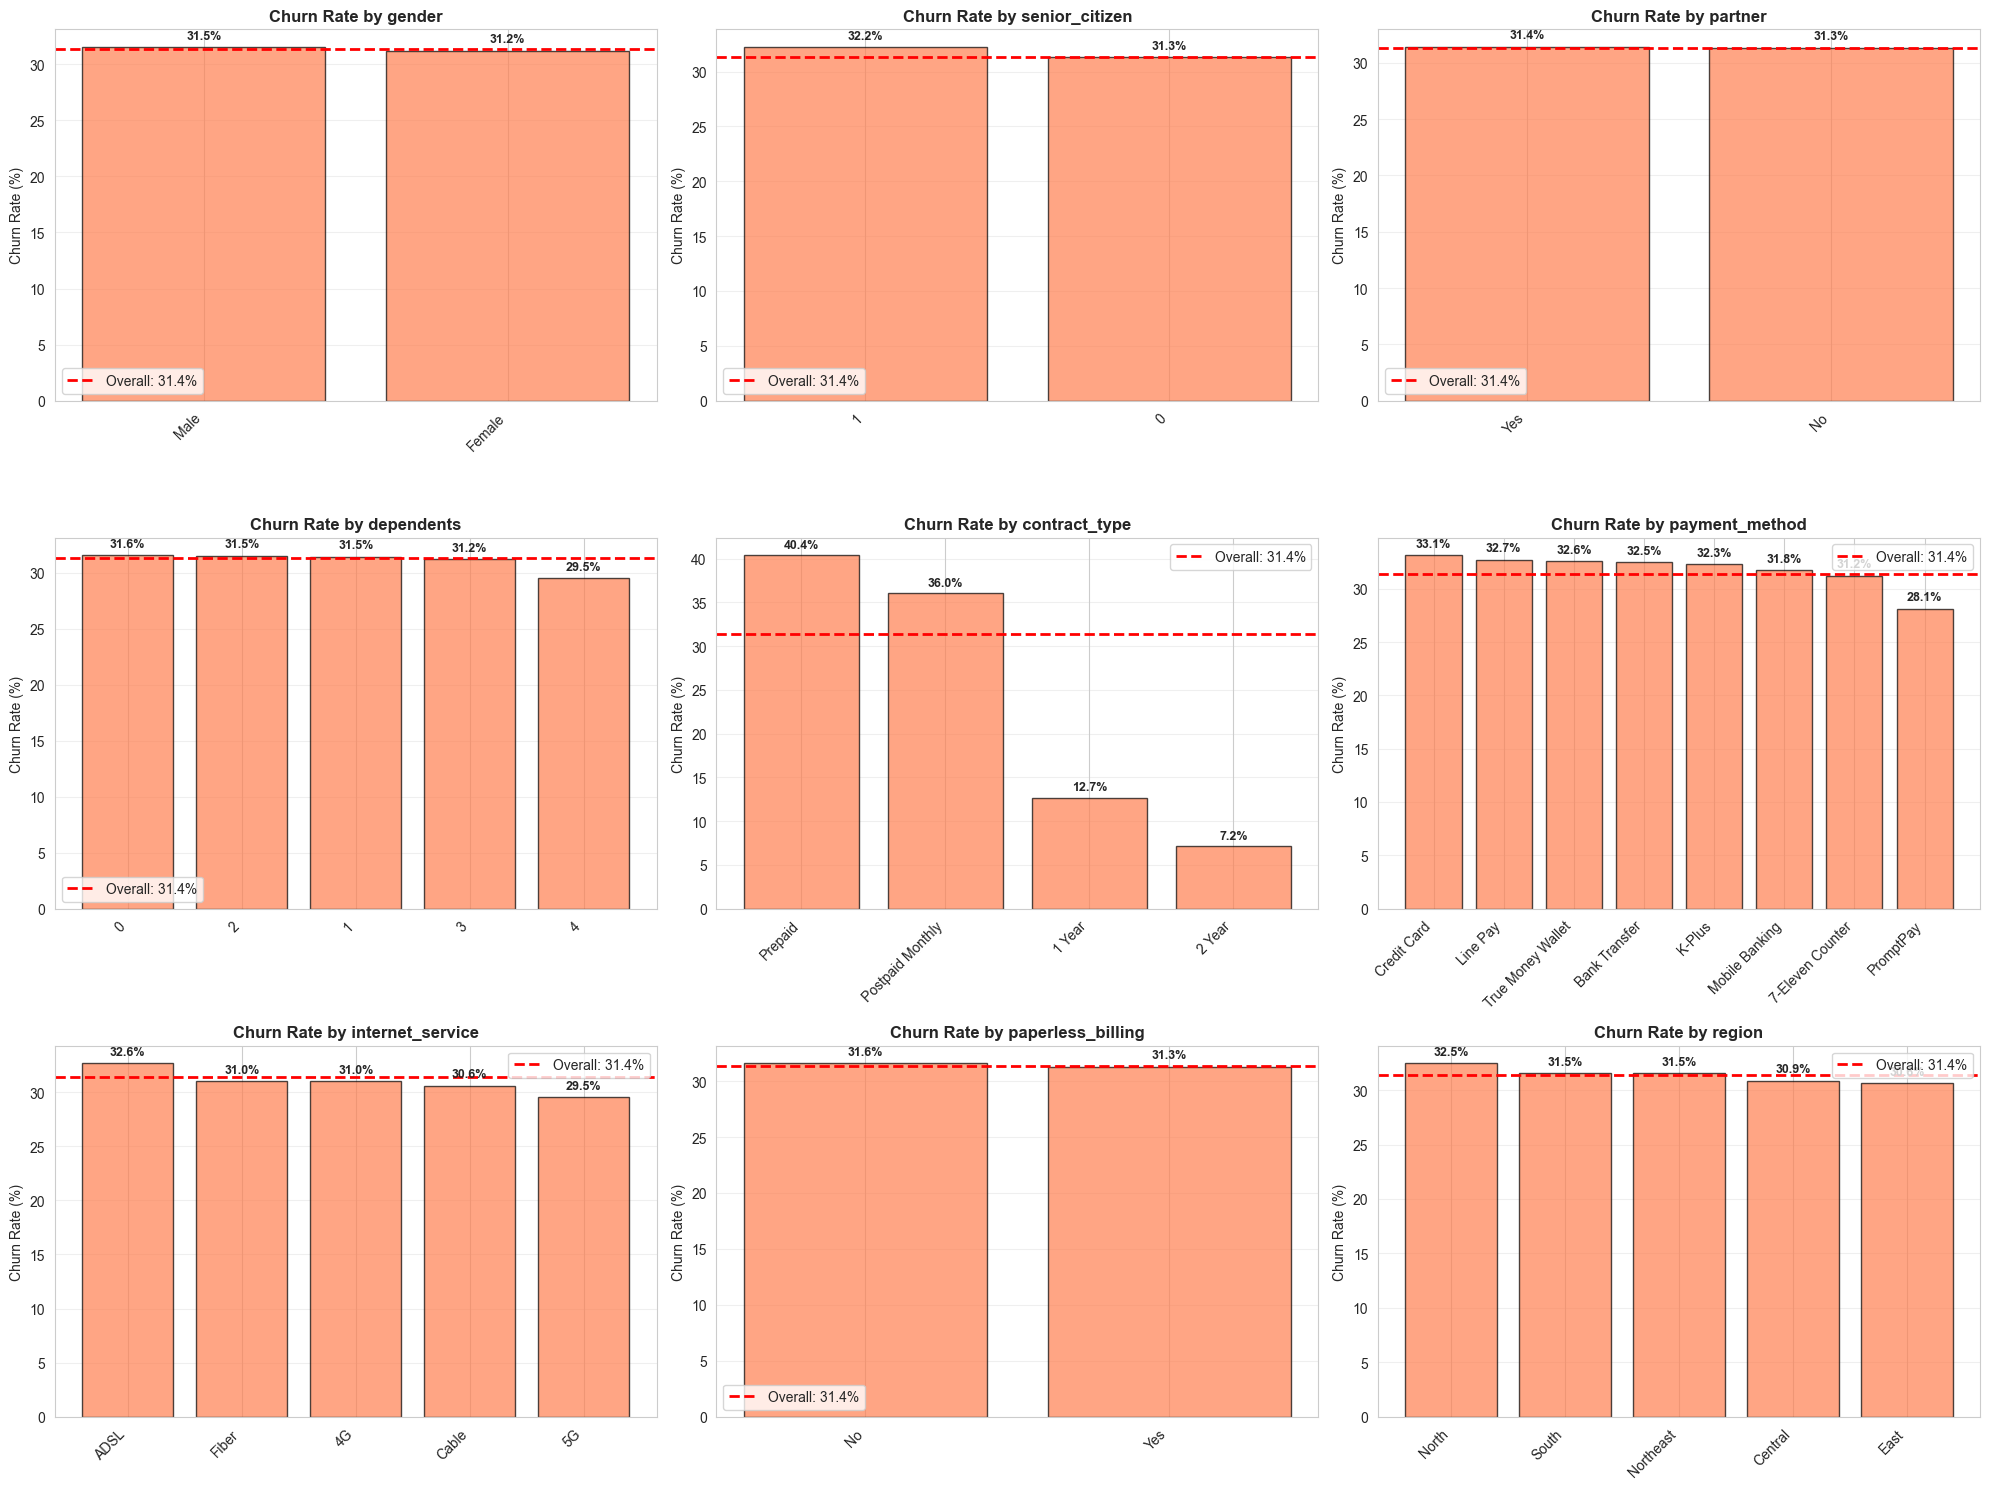


✓ Churn pattern visualization completed


In [93]:
# Visualize churn rates by key categories
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.ravel()

for idx, (feature, data) in enumerate(list(churn_analysis.items())[:9]):
    if idx < len(axes):
        # Create bar plot
        x_pos = np.arange(len(data))
        bars = axes[idx].bar(x_pos, data['churn_rate_pct'], color='coral', alpha=0.7, edgecolor='black')
        
        # Add value labels on bars
        for i, (bar, val) in enumerate(zip(bars, data['churn_rate_pct'])):
            axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                          f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        axes[idx].set_xticks(x_pos)
        axes[idx].set_xticklabels(data[feature], rotation=45, ha='right')
        axes[idx].set_title(f'Churn Rate by {feature}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Churn Rate (%)')
        axes[idx].axhline(df['churned'].mean() * 100, color='red', linestyle='--', 
                         linewidth=2, label=f'Overall: {df["churned"].mean()*100:.1f}%')
        axes[idx].legend()
        axes[idx].grid(axis='y', alpha=0.3)

# Remove empty subplots
for idx in range(len(churn_analysis), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

print("\n✓ Churn pattern visualization completed")


=== Churn Reasons Distribution ===
       Churn Reason  Count  Percentage
     Price Too High   9566       30.50
Poor Signal Quality   6256       19.94
   Competitor Offer   5550       17.69
       Poor Service   3083        9.83
          Relocated   2521        8.04
   Better Promotion   2517        8.02
     No Longer Need   1286        4.10
              Other    590        1.88


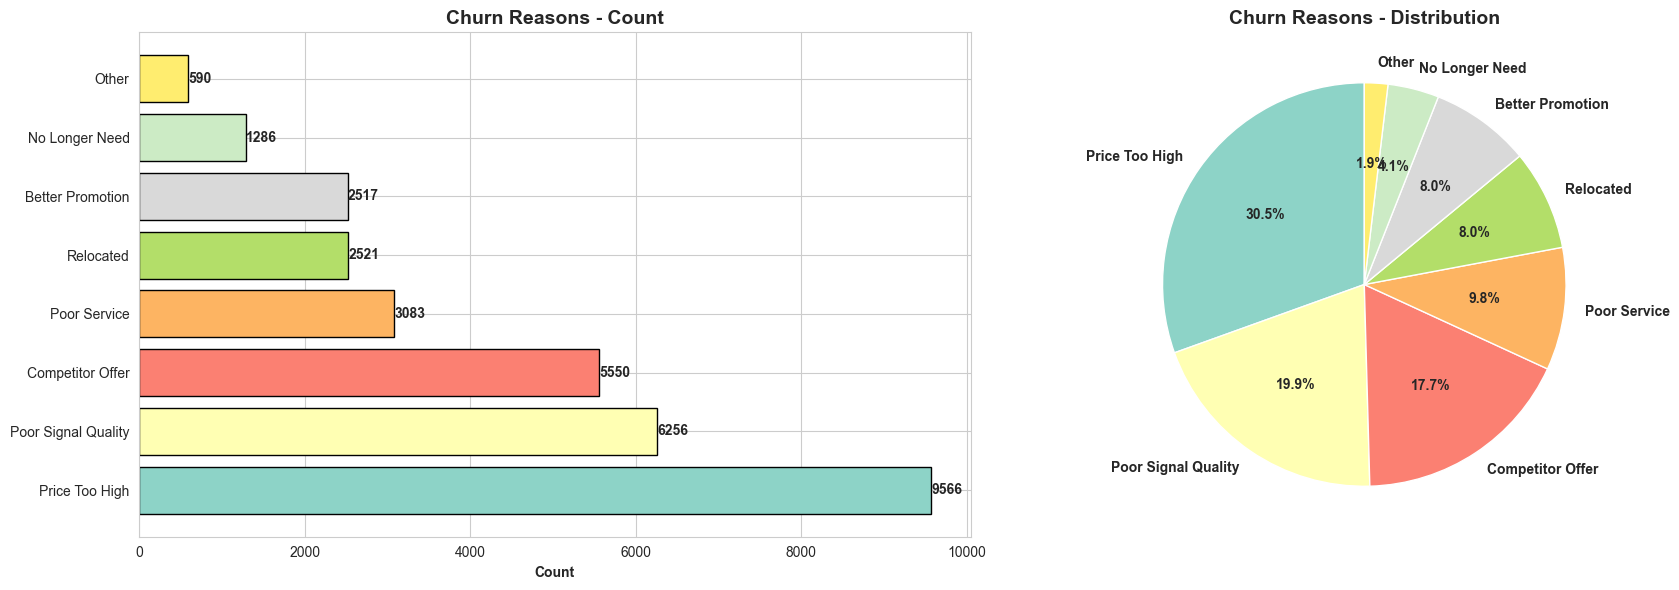

In [94]:
# Churn reasons analysis
churn_reasons = df[df['churned'] == 1]['churn_reason'].value_counts()
churn_reasons_pct = (churn_reasons / churn_reasons.sum() * 100).round(2)

print("\n=== Churn Reasons Distribution ===")
churn_reasons_df = pd.DataFrame({
    'Churn Reason': churn_reasons.index,
    'Count': churn_reasons.values,
    'Percentage': churn_reasons_pct.values
})
print(churn_reasons_df.to_string(index=False))

# Visualize churn reasons
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Bar chart
colors = plt.cm.Set3(np.linspace(0, 1, len(churn_reasons)))
bars = ax1.barh(churn_reasons.index, churn_reasons.values, color=colors, edgecolor='black')
ax1.set_xlabel('Count', fontweight='bold')
ax1.set_title('Churn Reasons - Count', fontsize=14, fontweight='bold')
for i, (bar, val) in enumerate(zip(bars, churn_reasons.values)):
    ax1.text(val + 5, bar.get_y() + bar.get_height()/2, str(val), 
             va='center', fontweight='bold')

# Pie chart
ax2.pie(churn_reasons.values, labels=churn_reasons.index, autopct='%1.1f%%', 
        colors=colors, startangle=90, textprops={'fontweight': 'bold'})
ax2.set_title('Churn Reasons - Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Advanced Correlation Analysis


=== Top Features Correlated with Churn ===

Positive Correlation (Risk Factors):
churned                        1.000000
price_increase_6months_thb     0.071900
postcode                       0.013994
num_payment_failures           0.012957
last_login_days_ago            0.009361
payment_delay_days             0.007271
website_visits_monthly         0.006030
num_plan_changes               0.004691
senior_citizen                 0.004645
num_support_tickets_6months    0.004195
dtype: float64

Negative Correlation (Retention Factors):
num_support_tickets           -0.000283
sms_count                     -0.003440
app_usage_hours_monthly       -0.003481
dependents                    -0.006426
data_usage_gb                 -0.011205
discount_amount_thb           -0.066902
monthly_charges_thb           -0.072063
multiple_lines                -0.079970
customer_satisfaction_score   -0.103881
total_charges_thb             -0.184953
dtype: float64


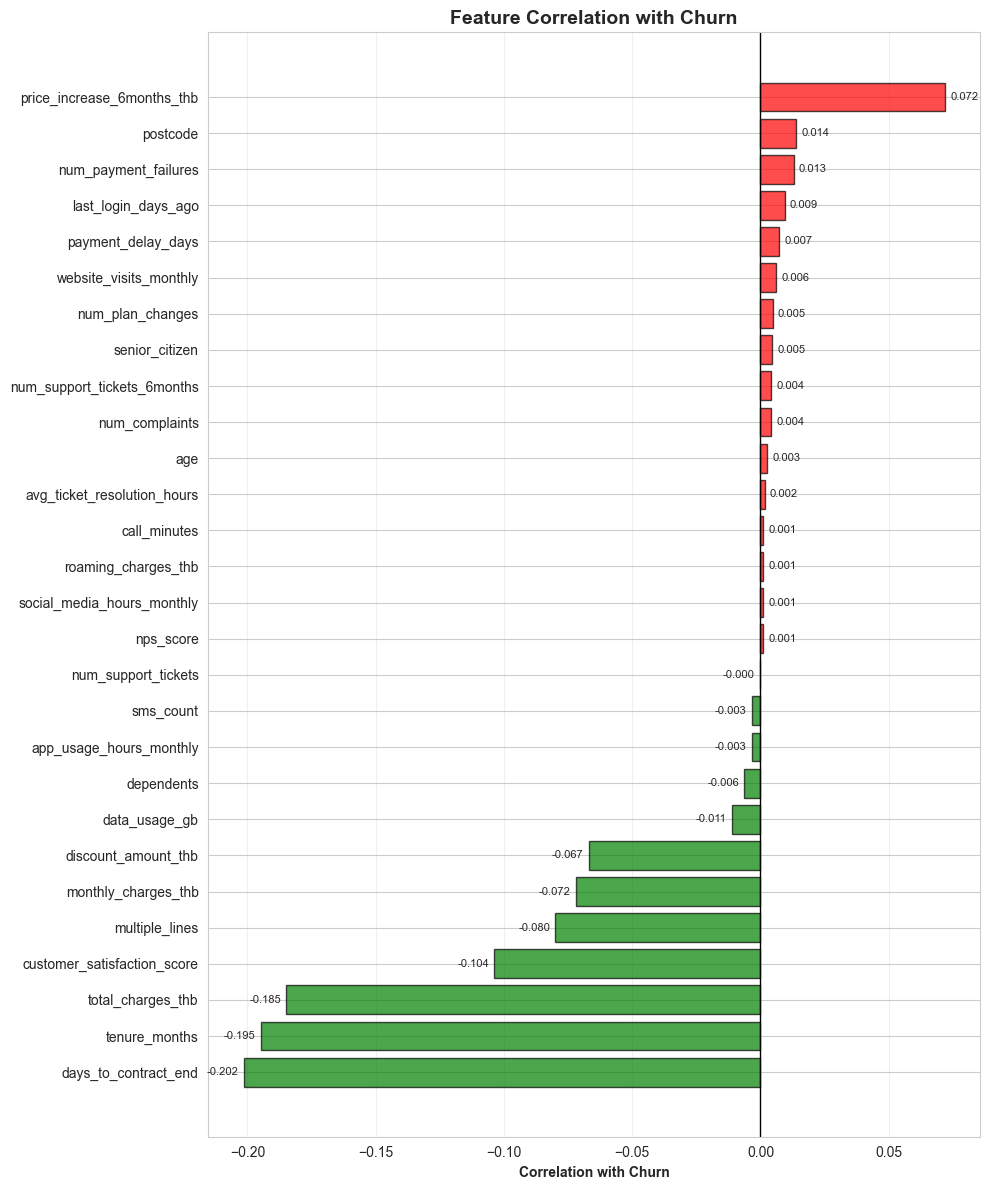

In [95]:
# Correlation with churn target
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'customer_id' in numerical_features:
    numerical_features.remove('customer_id')

churn_correlation = df[numerical_features].corrwith(df['churned']).sort_values(ascending=False)

print("\n=== Top Features Correlated with Churn ===")
print("\nPositive Correlation (Risk Factors):")
print(churn_correlation[churn_correlation > 0].head(10))
print("\nNegative Correlation (Retention Factors):")
print(churn_correlation[churn_correlation < 0].head(10))

# Visualize correlation with churn
fig, ax = plt.subplots(figsize=(10, 12))
churn_corr_sorted = churn_correlation.drop('churned').sort_values()
colors = ['red' if x > 0 else 'green' for x in churn_corr_sorted.values]
bars = ax.barh(range(len(churn_corr_sorted)), churn_corr_sorted.values, color=colors, alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(churn_corr_sorted)))
ax.set_yticklabels(churn_corr_sorted.index)
ax.set_xlabel('Correlation with Churn', fontweight='bold')
ax.set_title('Feature Correlation with Churn', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=1)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, churn_corr_sorted.values)):
    ax.text(val + 0.002 if val > 0 else val - 0.002, bar.get_y() + bar.get_height()/2, 
            f'{val:.3f}', va='center', ha='left' if val > 0 else 'right', fontsize=8)

plt.tight_layout()
plt.show()

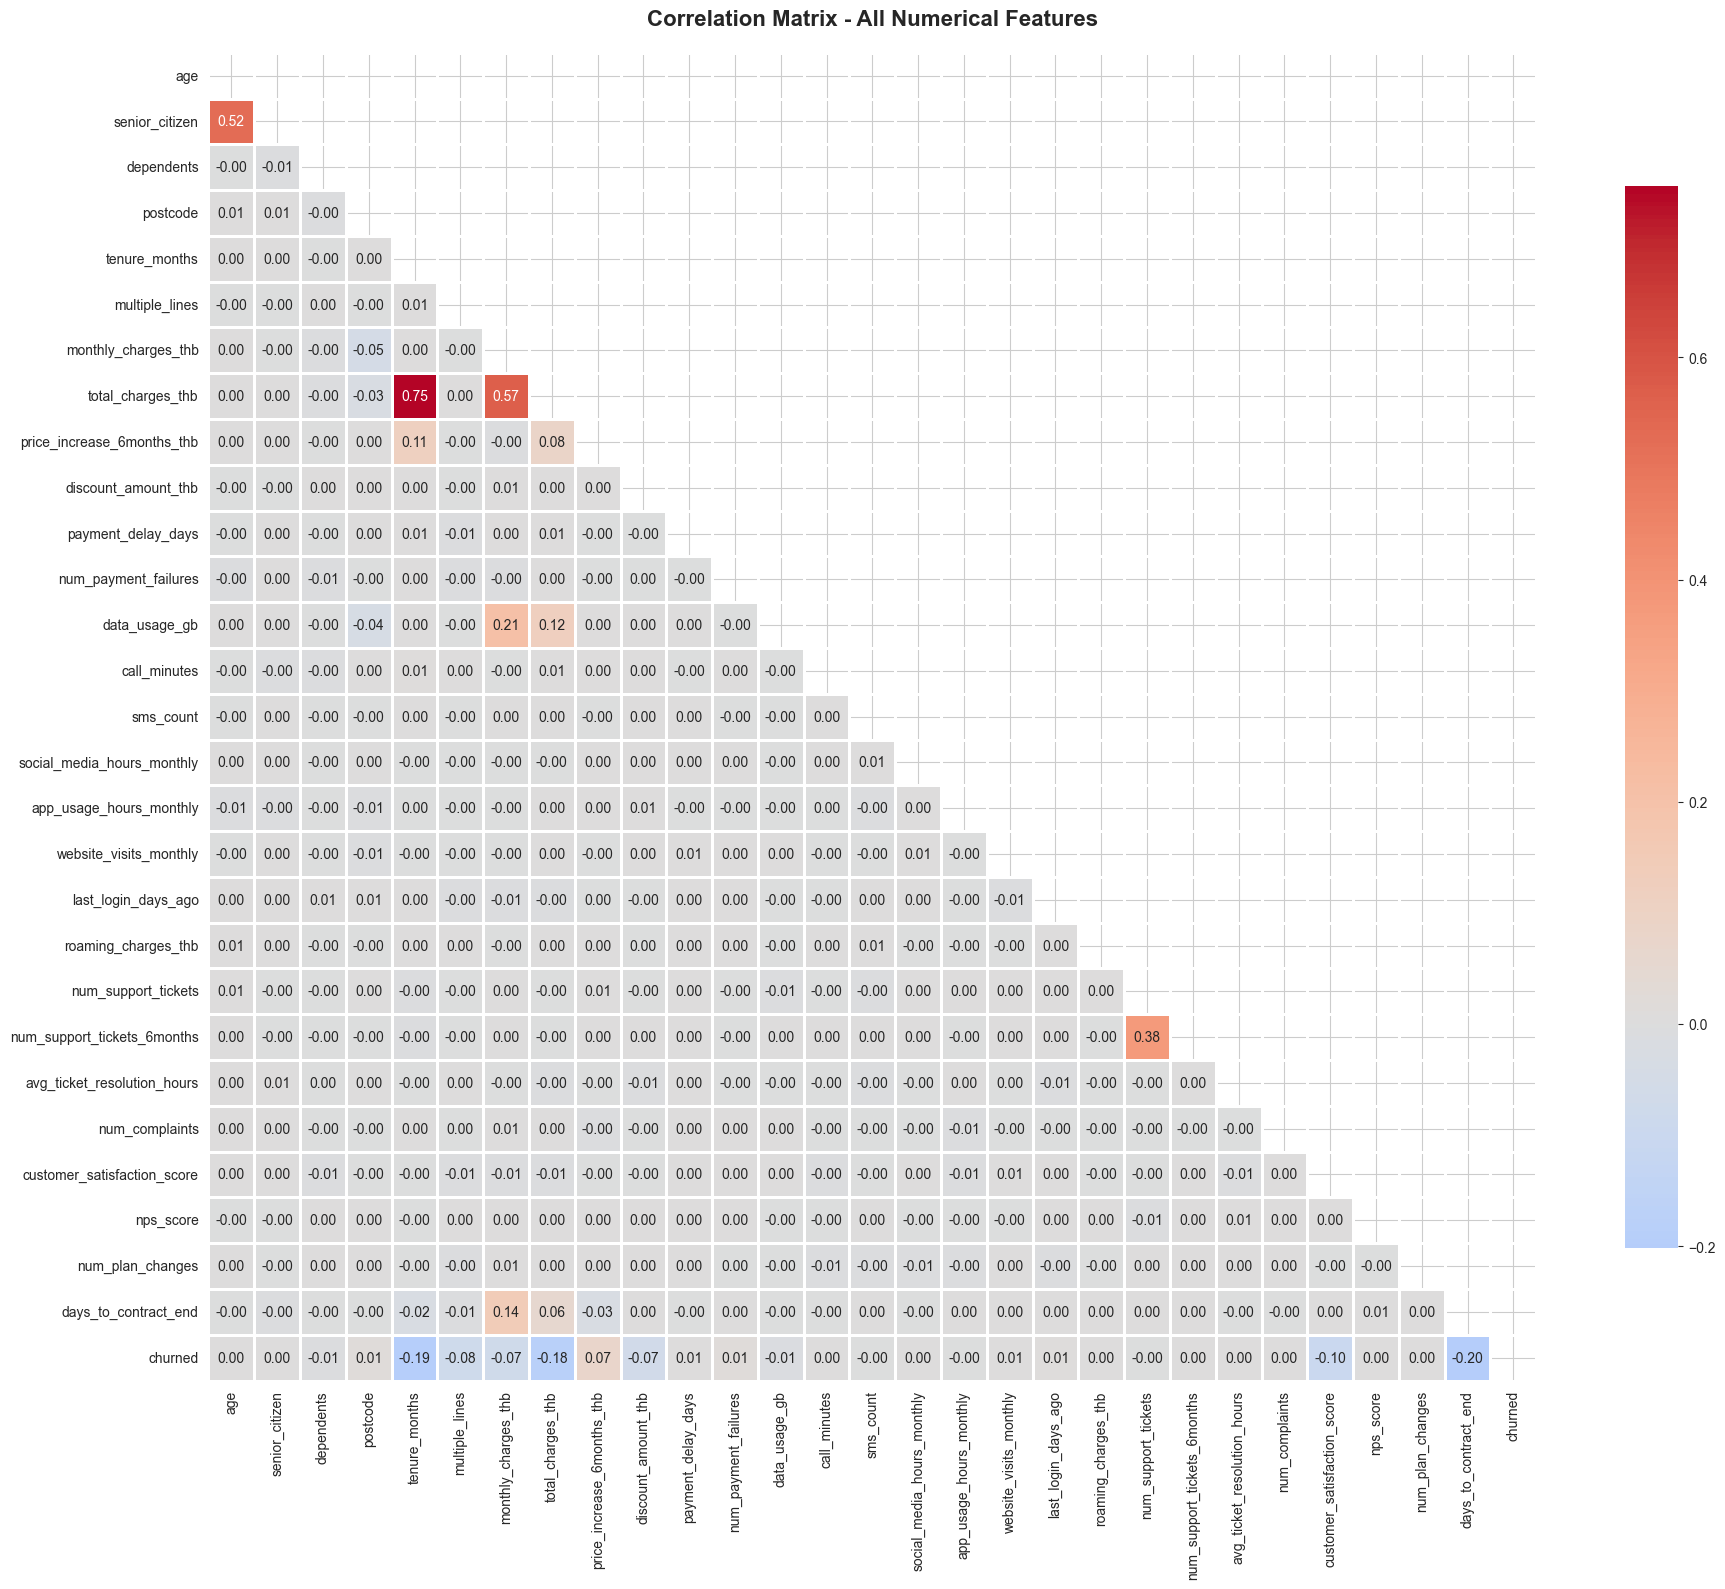


✓ Correlation analysis completed


In [96]:
# Full correlation heatmap
plt.figure(figsize=(20, 16))
correlation_matrix = df[numerical_features].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - All Numerical Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n✓ Correlation analysis completed")

In [97]:
# Find highly correlated feature pairs (potential multicollinearity)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False, key=abs)
    print("\n=== Highly Correlated Feature Pairs (|r| > 0.7) ===")
    print(high_corr_df.to_string(index=False))
else:
    print("\nNo highly correlated feature pairs found (|r| > 0.7)")


=== Highly Correlated Feature Pairs (|r| > 0.7) ===
    Feature 1         Feature 2  Correlation
tenure_months total_charges_thb     0.754705


## 5. Segmentation Analysis

In [98]:
# Customer segmentation by value (RFM-inspired)
df['customer_value_segment'] = pd.cut(df['total_charges_thb'], 
                                       bins=[0, 10000, 30000, 60000, float('inf')],
                                       labels=['Low Value', 'Medium Value', 'High Value', 'Premium'])

df['tenure_segment'] = pd.cut(df['tenure_months'], 
                              bins=[0, 6, 12, 24, 48, float('inf')],
                              labels=['New (0-6m)', 'Growing (6-12m)', 'Established (1-2y)', 
                                     'Loyal (2-4y)', 'Very Loyal (4y+)'])

df['usage_segment'] = pd.cut(df['data_usage_gb'], 
                             bins=[0, 20, 50, 100, float('inf')],
                             labels=['Light User', 'Moderate User', 'Heavy User', 'Power User'])

# Analyze churn by segments
print("\n=== Churn Analysis by Customer Segments ===")

for segment_col in ['customer_value_segment', 'tenure_segment', 'usage_segment']:
    segment_analysis = df.groupby(segment_col).agg({
        'churned': ['count', 'sum', 'mean'],
        'monthly_charges_thb': 'mean',
        'customer_satisfaction_score': 'mean'
    }).round(2)
    segment_analysis.columns = ['Total', 'Churned', 'Churn_Rate', 'Avg_Monthly_Charges', 'Avg_Satisfaction']
    print(f"\n{segment_col.upper()}:")
    print(segment_analysis)


=== Churn Analysis by Customer Segments ===

CUSTOMER_VALUE_SEGMENT:
                        Total  Churned  Churn_Rate  Avg_Monthly_Charges  \
customer_value_segment                                                    
Low Value               21193    10149        0.48               775.85   
Medium Value            38078    11467        0.30               857.07   
High Value              29791     6766        0.23              1118.17   
Premium                  9274     1939        0.21              1602.94   

                        Avg_Satisfaction  
customer_value_segment                    
Low Value                           4.28  
Medium Value                        4.28  
High Value                          4.27  
Premium                             4.26  

TENURE_SEGMENT:
                    Total  Churned  Churn_Rate  Avg_Monthly_Charges  \
tenure_segment                                                        
New (0-6m)          10552     5658        0.54               9

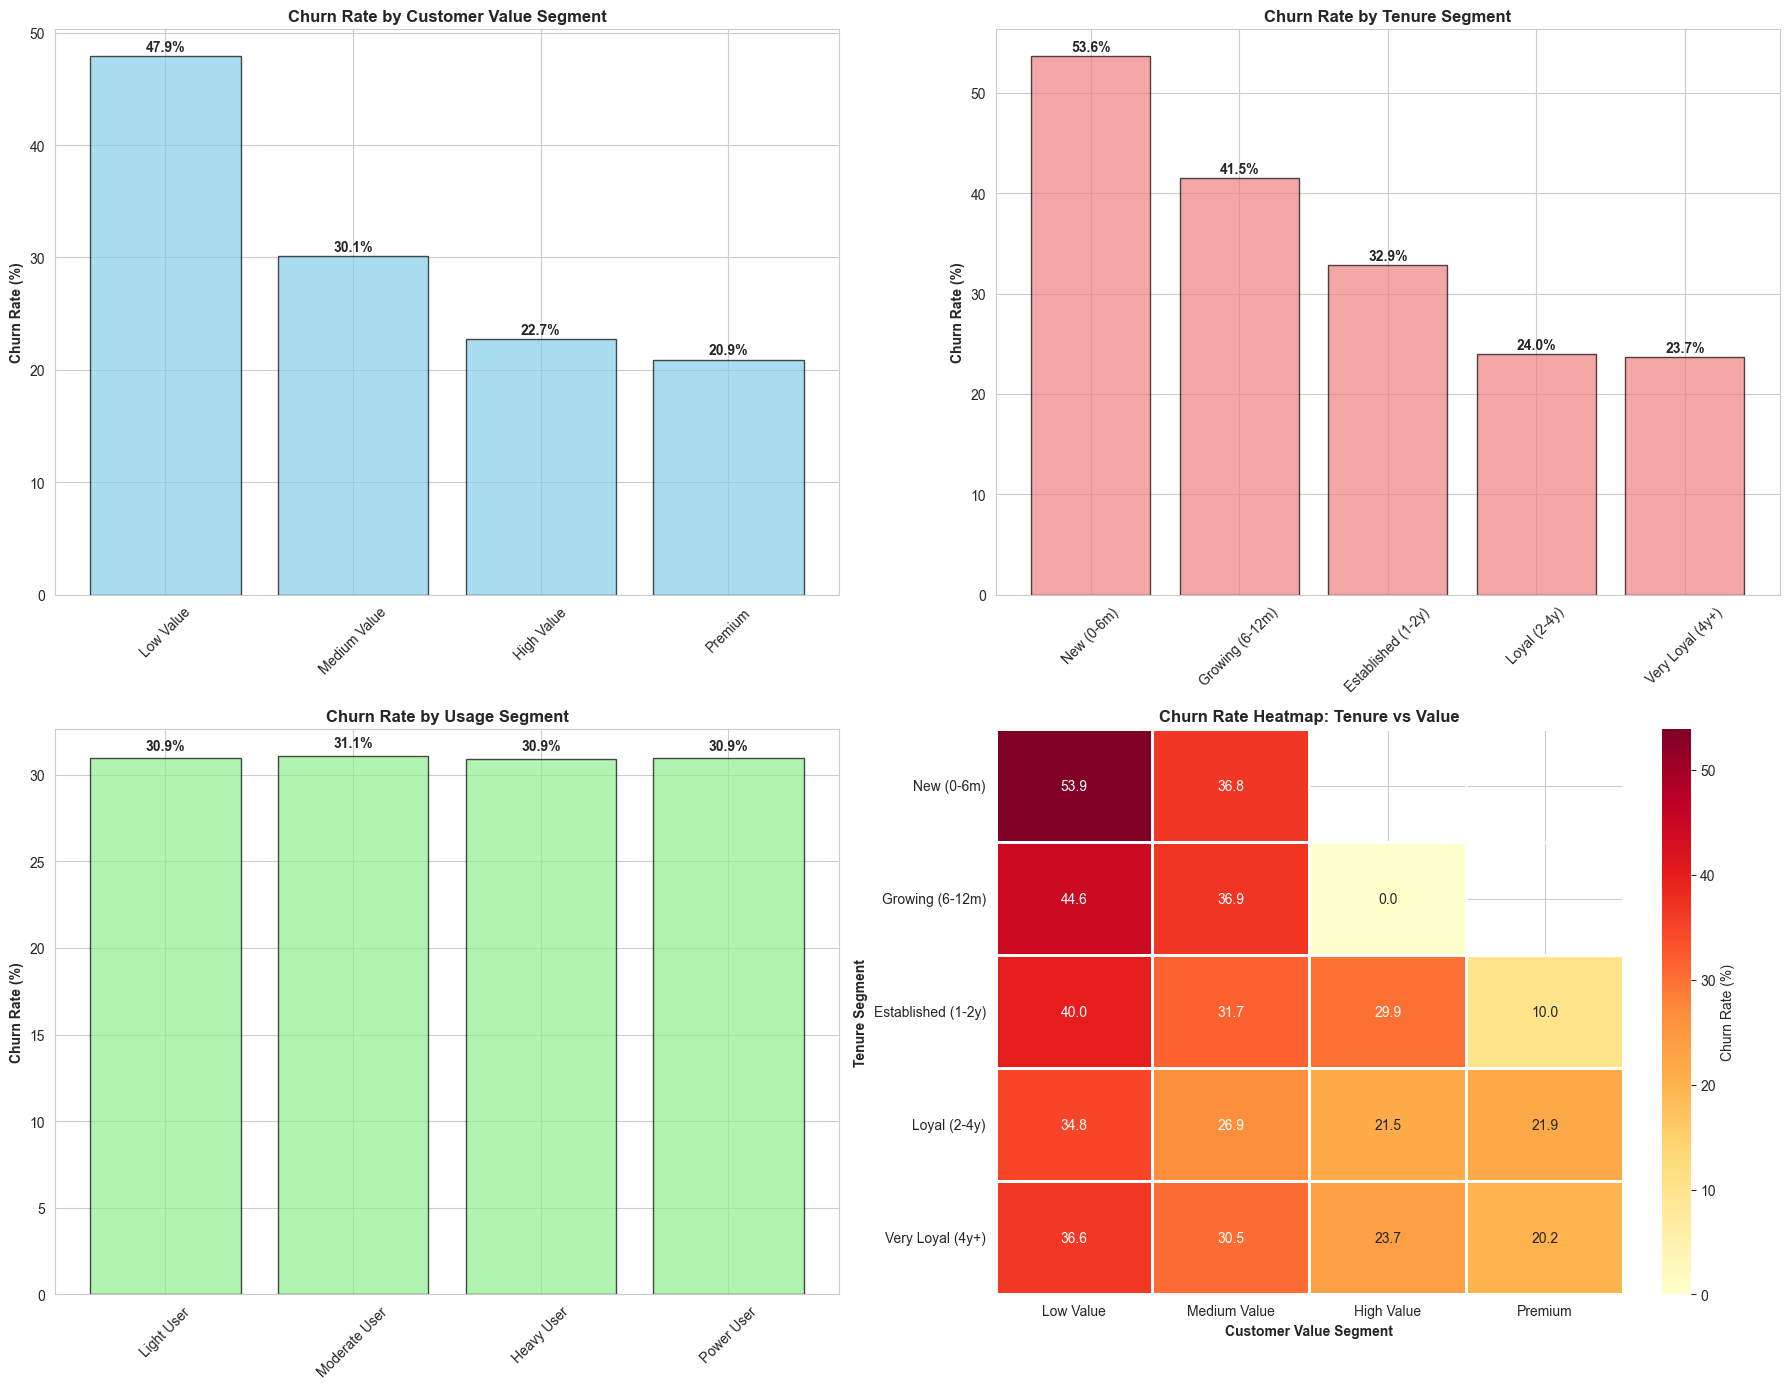


✓ Segmentation analysis completed


In [99]:
# Visualize segmentation analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Churn rate by value segment
value_churn = df.groupby('customer_value_segment')['churned'].mean() * 100
axes[0, 0].bar(range(len(value_churn)), value_churn.values, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xticks(range(len(value_churn)))
axes[0, 0].set_xticklabels(value_churn.index, rotation=45)
axes[0, 0].set_ylabel('Churn Rate (%)', fontweight='bold')
axes[0, 0].set_title('Churn Rate by Customer Value Segment', fontsize=12, fontweight='bold')
for i, v in enumerate(value_churn.values):
    axes[0, 0].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

# 2. Churn rate by tenure segment
tenure_churn = df.groupby('tenure_segment')['churned'].mean() * 100
axes[0, 1].bar(range(len(tenure_churn)), tenure_churn.values, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xticks(range(len(tenure_churn)))
axes[0, 1].set_xticklabels(tenure_churn.index, rotation=45)
axes[0, 1].set_ylabel('Churn Rate (%)', fontweight='bold')
axes[0, 1].set_title('Churn Rate by Tenure Segment', fontsize=12, fontweight='bold')
for i, v in enumerate(tenure_churn.values):
    axes[0, 1].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

# 3. Churn rate by usage segment
usage_churn = df.groupby('usage_segment')['churned'].mean() * 100
axes[1, 0].bar(range(len(usage_churn)), usage_churn.values, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_xticks(range(len(usage_churn)))
axes[1, 0].set_xticklabels(usage_churn.index, rotation=45)
axes[1, 0].set_ylabel('Churn Rate (%)', fontweight='bold')
axes[1, 0].set_title('Churn Rate by Usage Segment', fontsize=12, fontweight='bold')
for i, v in enumerate(usage_churn.values):
    axes[1, 0].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

# 4. Combined segment heatmap
segment_matrix = df.groupby(['tenure_segment', 'customer_value_segment'])['churned'].mean() * 100
segment_matrix = segment_matrix.unstack(fill_value=0)
sns.heatmap(segment_matrix, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1, 1], 
            cbar_kws={'label': 'Churn Rate (%)'}, linewidths=1)
axes[1, 1].set_title('Churn Rate Heatmap: Tenure vs Value', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Customer Value Segment', fontweight='bold')
axes[1, 1].set_ylabel('Tenure Segment', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Segmentation analysis completed")

## 6. Cohort Analysis

In [100]:
# Convert account created date to datetime
df['account_created_date'] = pd.to_datetime(df['account_created_date'])
df['cohort_month'] = df['account_created_date'].dt.to_period('M')

# Cohort analysis
cohort_data = df.groupby('cohort_month').agg({
    'customer_id': 'count',
    'churned': 'sum',
    'tenure_months': 'mean',
    'monthly_charges_thb': 'mean',
    'total_charges_thb': 'mean'
}).reset_index()

cohort_data.columns = ['Cohort', 'Total_Customers', 'Churned', 'Avg_Tenure', 'Avg_Monthly_Charges', 'Avg_Total_Charges']
cohort_data['Churn_Rate'] = (cohort_data['Churned'] / cohort_data['Total_Customers'] * 100).round(2)
cohort_data['Cohort'] = cohort_data['Cohort'].astype(str)

print("\n=== Cohort Analysis ===")
print(cohort_data.to_string(index=False))


=== Cohort Analysis ===
 Cohort  Total_Customers  Churned  Avg_Tenure  Avg_Monthly_Charges  Avg_Total_Charges  Churn_Rate
2020-01             1832      419   56.834061           982.887555       55768.378215       22.87
2020-02             1597      356   55.851597           997.922354       55715.038071       22.29
2020-03             1737      397   54.844560           990.719632       54350.444876       22.86
2020-04             1721      406   53.842533           988.929111       53306.089367       23.59
2020-05             1760      433   52.821591           973.764773       51388.013528       24.60
2020-06             1743      438   51.795754          1000.640849       51759.244676       25.13
2020-07             1815      427   50.770248          1008.488154       51223.465460       23.53
2020-08             1827      450   49.732895           991.097427       49324.618424       24.63
2020-09             1700      391   48.725294           982.006471       47801.693829       2

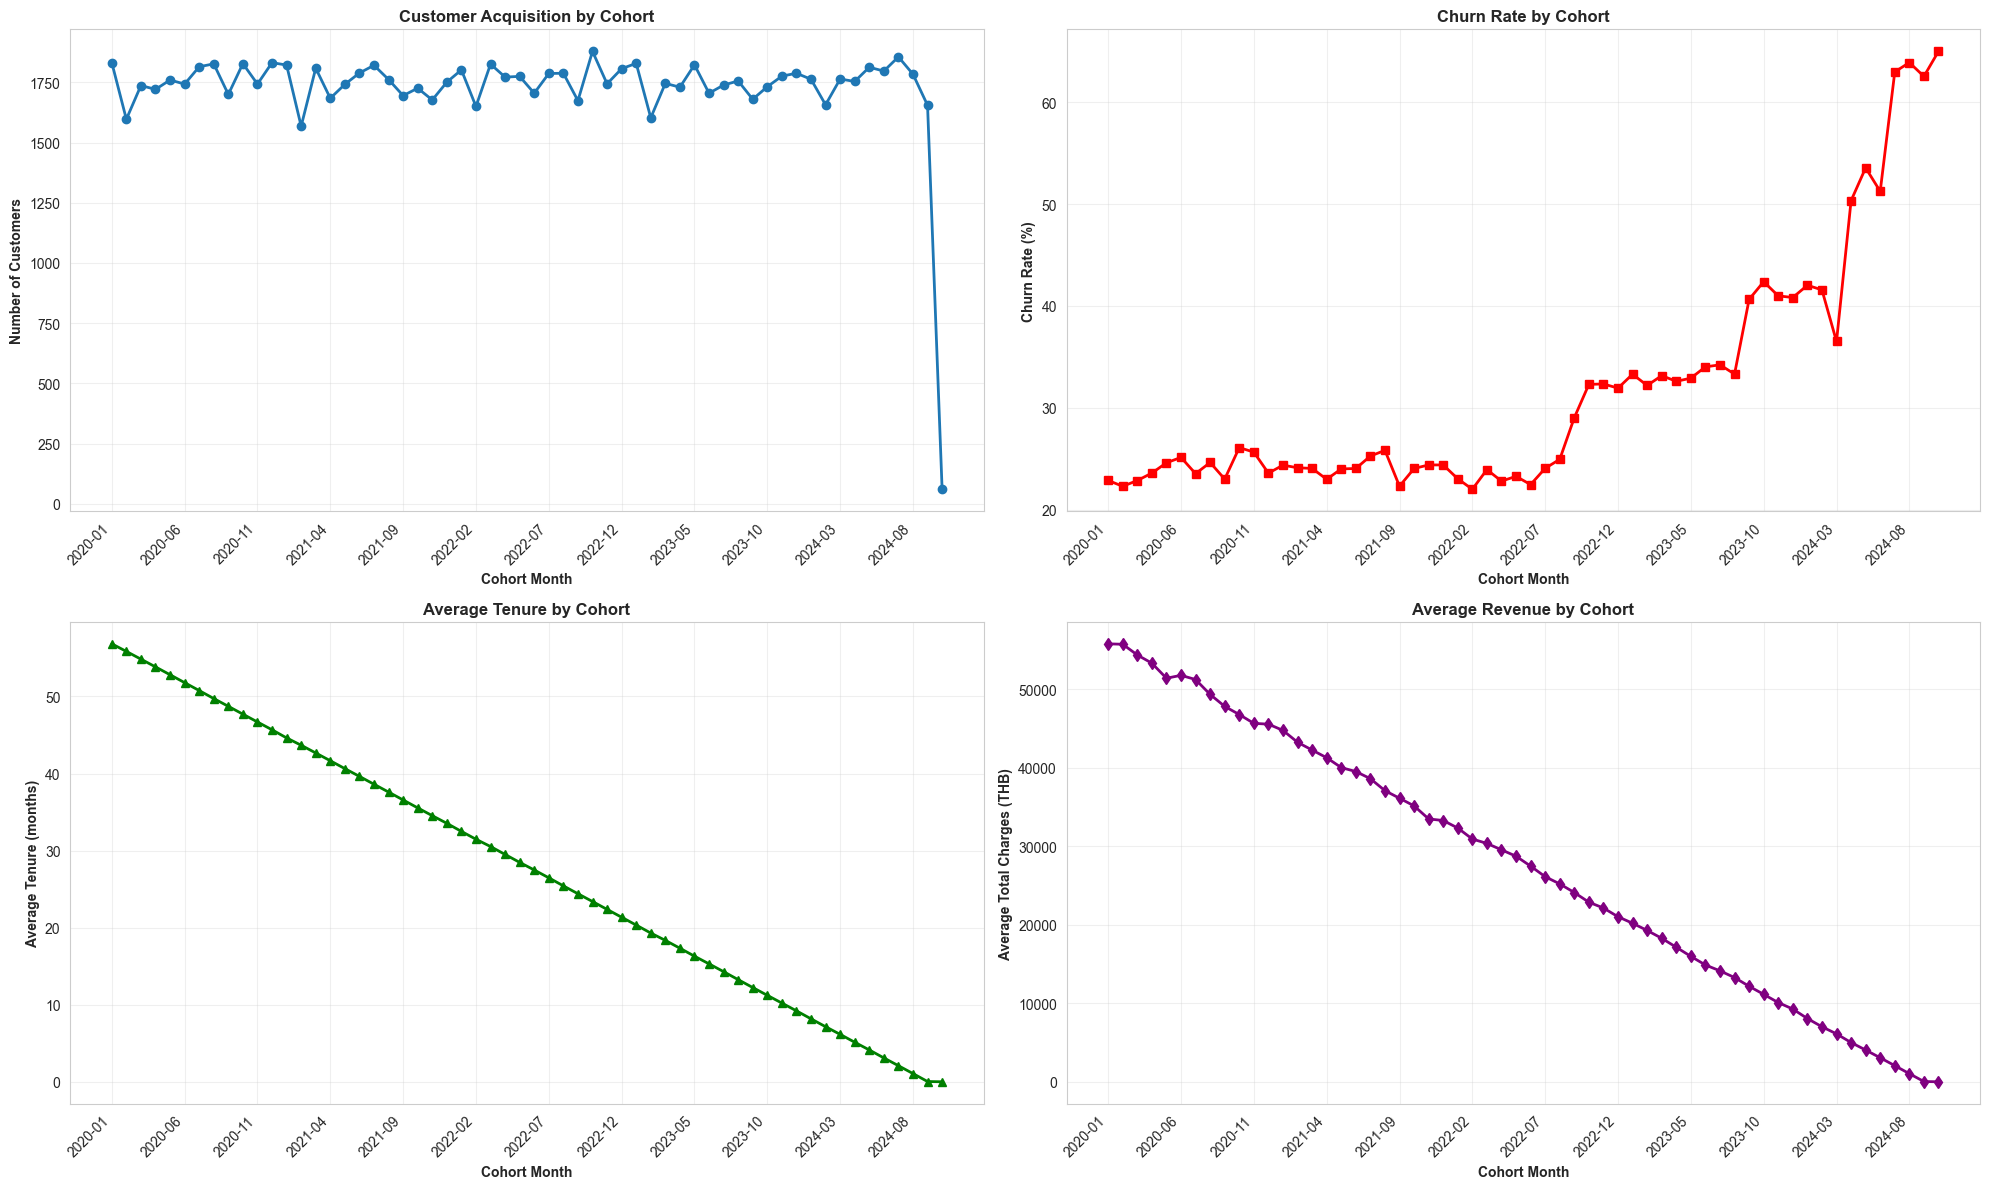


✓ Cohort analysis completed


In [101]:
# Visualize cohort trends
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Prepare x-axis: Show only every Nth label to avoid crowding
n_cohorts = len(cohort_data)
step = max(1, n_cohorts // 10)  # Show ~10 labels max
x_positions = range(n_cohorts)
x_labels = cohort_data['Cohort'].tolist()

# 1. Customer acquisition by cohort
axes[0, 0].plot(x_positions, cohort_data['Total_Customers'], marker='o', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('Cohort Month', fontweight='bold')
axes[0, 0].set_ylabel('Number of Customers', fontweight='bold')
axes[0, 0].set_title('Customer Acquisition by Cohort', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks([i for i in x_positions if i % step == 0])
axes[0, 0].set_xticklabels([x_labels[i] for i in x_positions if i % step == 0], rotation=45, ha='right')
axes[0, 0].grid(True, alpha=0.3)

# 2. Churn rate by cohort
axes[0, 1].plot(x_positions, cohort_data['Churn_Rate'], marker='s', 
                color='red', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('Cohort Month', fontweight='bold')
axes[0, 1].set_ylabel('Churn Rate (%)', fontweight='bold')
axes[0, 1].set_title('Churn Rate by Cohort', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks([i for i in x_positions if i % step == 0])
axes[0, 1].set_xticklabels([x_labels[i] for i in x_positions if i % step == 0], rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3)

# 3. Average tenure by cohort
axes[1, 0].plot(x_positions, cohort_data['Avg_Tenure'], marker='^', 
                color='green', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Cohort Month', fontweight='bold')
axes[1, 0].set_ylabel('Average Tenure (months)', fontweight='bold')
axes[1, 0].set_title('Average Tenure by Cohort', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks([i for i in x_positions if i % step == 0])
axes[1, 0].set_xticklabels([x_labels[i] for i in x_positions if i % step == 0], rotation=45, ha='right')
axes[1, 0].grid(True, alpha=0.3)

# 4. Average revenue by cohort
axes[1, 1].plot(x_positions, cohort_data['Avg_Total_Charges'], marker='d', 
                color='purple', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Cohort Month', fontweight='bold')
axes[1, 1].set_ylabel('Average Total Charges (THB)', fontweight='bold')
axes[1, 1].set_title('Average Revenue by Cohort', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks([i for i in x_positions if i % step == 0])
axes[1, 1].set_xticklabels([x_labels[i] for i in x_positions if i % step == 0], rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Cohort analysis completed")

## 7. Service Usage Deep Dive

In [102]:
# Analyze service adoption and its impact on churn
service_features = ['online_security', 'online_backup', 'device_protection', 'tech_support',
                   'has_netflix_thai', 'has_line_tv', 'has_true_visions', 'multiple_lines']

service_analysis = {}
for service in service_features:
    if service in df.columns:
        service_impact = df.groupby(service)['churned'].agg(['count', 'sum', 'mean']).reset_index()
        service_impact.columns = [service, 'total', 'churned', 'churn_rate']
        service_analysis[service] = service_impact

print("\n=== Service Adoption Impact on Churn ===")
for service, data in service_analysis.items():
    print(f"\n{service.upper()}:")
    data['churn_rate_pct'] = (data['churn_rate'] * 100).round(2)
    print(data.to_string(index=False))


=== Service Adoption Impact on Churn ===

ONLINE_SECURITY:
online_security  total  churned  churn_rate  churn_rate_pct
             No  69540    22866    0.328818           32.88
            Yes  30460     8503    0.279153           27.92

ONLINE_BACKUP:
online_backup  total  churned  churn_rate  churn_rate_pct
           No  73698    23150    0.314120           31.41
          Yes  26302     8219    0.312486           31.25

DEVICE_PROTECTION:
device_protection  total  churned  churn_rate  churn_rate_pct
               No  65140    20373    0.312757           31.28
              Yes  34860    10996    0.315433           31.54

TECH_SUPPORT:
tech_support  total  churned  churn_rate  churn_rate_pct
          No  78425    25851    0.329627           32.96
         Yes  21575     5518    0.255759           25.58

HAS_NETFLIX_THAI:
has_netflix_thai  total  churned  churn_rate  churn_rate_pct
              No  73777    23639    0.320412           32.04
             Yes  26223     7730    0


=== Churn by Number of Services Used ===
                Total  Churned  Churn_Rate  Avg_Monthly_Charges  Avg_Tenure
total_services                                                             
0               19080     6700        0.35               613.87       28.47
1               19695     6755        0.34               845.62       28.23
2               27494     8478        0.31              1011.61       28.48
3               21073     6017        0.29              1185.61       28.38
4                9627     2579        0.27              1351.59       28.64
5                2639      724        0.27              1535.27       28.75
6                 367      110        0.30              1692.89       27.43
7                  25        6        0.24              1963.84       37.48


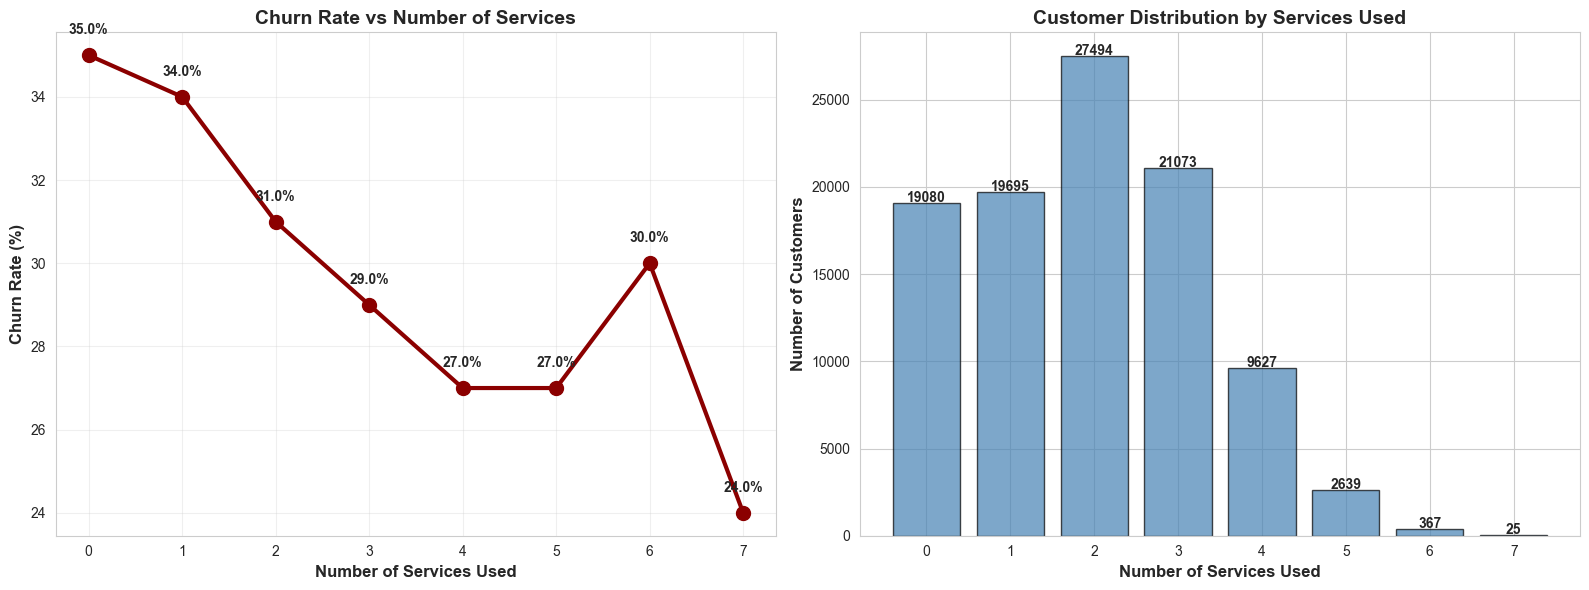


✓ Service usage analysis completed


In [103]:
# Calculate number of services used
# Convert Yes/No to 1/0 for counting
service_cols_to_check = ['online_security', 'online_backup', 'device_protection', 'tech_support',
                         'has_netflix_thai', 'has_line_tv', 'has_true_visions']

for col in service_cols_to_check:
    if col in df.columns:
        df[f'{col}_binary'] = df[col].map({'Yes': 1, 'No': 0, True: 1, False: 0}).fillna(0)

binary_cols = [f'{col}_binary' for col in service_cols_to_check if f'{col}_binary' in df.columns]
df['total_services'] = df[binary_cols].sum(axis=1)

# Analyze churn by number of services
services_churn = df.groupby('total_services').agg({
    'churned': ['count', 'sum', 'mean'],
    'monthly_charges_thb': 'mean',
    'tenure_months': 'mean'
}).round(2)
services_churn.columns = ['Total', 'Churned', 'Churn_Rate', 'Avg_Monthly_Charges', 'Avg_Tenure']

print("\n=== Churn by Number of Services Used ===")
print(services_churn)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Churn rate by number of services
ax1.plot(services_churn.index, services_churn['Churn_Rate'] * 100, marker='o', 
         linewidth=3, markersize=10, color='darkred')
ax1.set_xlabel('Number of Services Used', fontweight='bold', fontsize=12)
ax1.set_ylabel('Churn Rate (%)', fontweight='bold', fontsize=12)
ax1.set_title('Churn Rate vs Number of Services', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
for x, y in zip(services_churn.index, services_churn['Churn_Rate'] * 100):
    ax1.text(x, y + 0.5, f'{y:.1f}%', ha='center', fontweight='bold')

# Distribution of customers by number of services
service_dist = df['total_services'].value_counts().sort_index()
ax2.bar(service_dist.index, service_dist.values, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Number of Services Used', fontweight='bold', fontsize=12)
ax2.set_ylabel('Number of Customers', fontweight='bold', fontsize=12)
ax2.set_title('Customer Distribution by Services Used', fontsize=14, fontweight='bold')
for x, y in zip(service_dist.index, service_dist.values):
    ax2.text(x, y + 50, str(y), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Service usage analysis completed")

## 8. Payment Behavior Analysis

In [104]:
# Payment behavior deep dive
payment_metrics = ['payment_delay_days', 'num_payment_failures', 'price_increase_6months_thb', 'discount_amount_thb']

print("\n=== Payment Behavior by Churn Status ===")
for metric in payment_metrics:
    if metric in df.columns:
        comparison = df.groupby('churned')[metric].agg(['mean', 'median', 'std']).round(2)
        comparison.index = ['Active', 'Churned']
        print(f"\n{metric.upper()}:")
        print(comparison)
        
        # Statistical test
        active_data = df[df['churned'] == 0][metric].dropna()
        churned_data = df[df['churned'] == 1][metric].dropna()
        if len(active_data) > 0 and len(churned_data) > 0:
            stat, p_value = mannwhitneyu(active_data, churned_data, alternative='two-sided')
            print(f"Mann-Whitney U test p-value: {p_value:.4f}")
            if p_value < 0.05:
                print("✓ Statistically significant difference (p < 0.05)")
            else:
                print("No statistically significant difference (p >= 0.05)")


=== Payment Behavior by Churn Status ===

PAYMENT_DELAY_DAYS:
         mean  median   std
Active   2.51     2.0  2.94
Churned  2.56     2.0  3.09


Mann-Whitney U test p-value: 0.3616
No statistically significant difference (p >= 0.05)

NUM_PAYMENT_FAILURES:
         mean  median   std
Active   0.50     0.0  0.70
Churned  0.52     0.0  0.74
Mann-Whitney U test p-value: 0.0828
No statistically significant difference (p >= 0.05)

PRICE_INCREASE_6MONTHS_THB:
          mean  median    std
Active   29.34     0.0  57.90
Churned  38.82     0.0  67.47
Mann-Whitney U test p-value: 0.0000
✓ Statistically significant difference (p < 0.05)

DISCOUNT_AMOUNT_THB:
          mean  median     std
Active   92.99     0.0  145.19
Churned  72.51     0.0  133.87
Mann-Whitney U test p-value: 0.0000
✓ Statistically significant difference (p < 0.05)


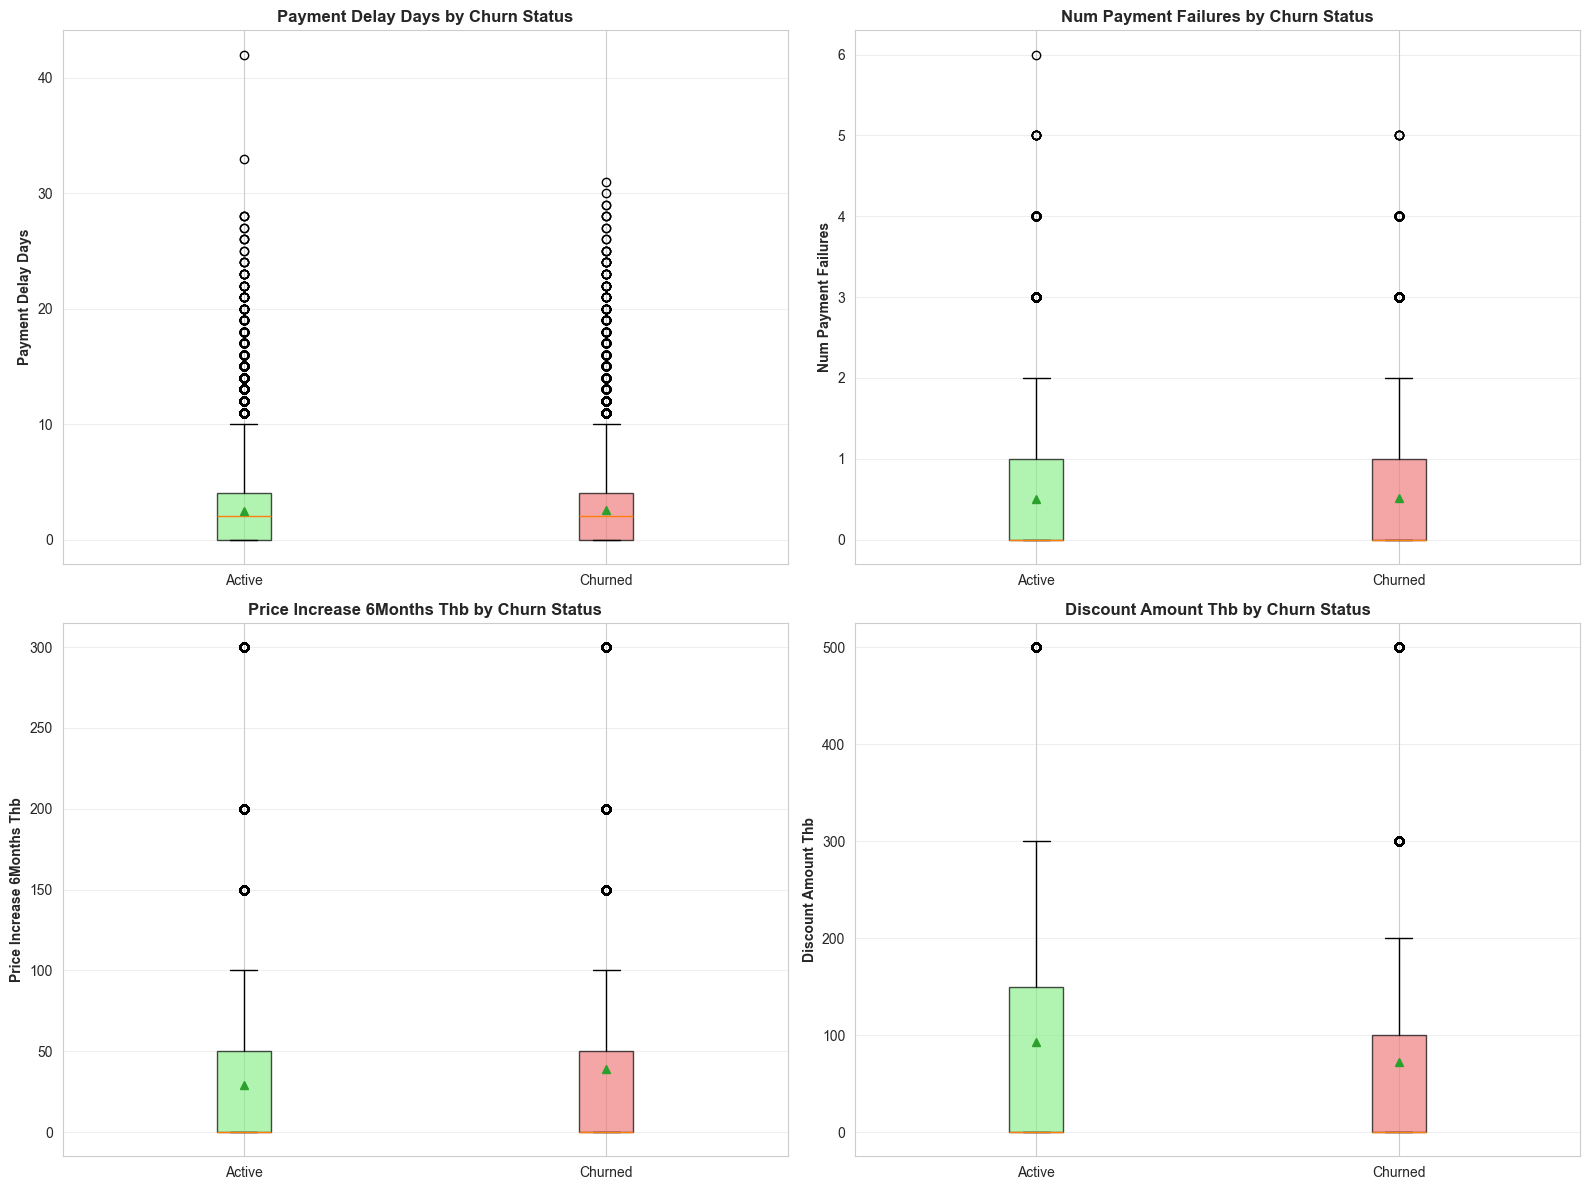


✓ Payment behavior analysis completed


In [105]:
# Visualize payment behavior
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, metric in enumerate(payment_metrics):
    if metric in df.columns:
        row = idx // 2
        col = idx % 2
        
        # Box plot comparison
        data_to_plot = [df[df['churned'] == 0][metric].dropna(), 
                       df[df['churned'] == 1][metric].dropna()]
        bp = axes[row, col].boxplot(data_to_plot, labels=['Active', 'Churned'], 
                                    patch_artist=True, showmeans=True)
        
        # Color the boxes
        colors = ['lightgreen', 'lightcoral']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        axes[row, col].set_ylabel(metric.replace('_', ' ').title(), fontweight='bold')
        axes[row, col].set_title(f'{metric.replace("_", " ").title()} by Churn Status', 
                                fontsize=12, fontweight='bold')
        axes[row, col].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Payment behavior analysis completed")

## 9. Customer Support Impact

In [106]:
# Support ticket analysis
support_metrics = ['num_support_tickets', 'num_support_tickets_6months', 
                  'avg_ticket_resolution_hours', 'num_complaints', 'customer_satisfaction_score']

print("\n=== Customer Support Metrics by Churn Status ===")
support_comparison = df.groupby('churned')[support_metrics].agg(['mean', 'median', 'std']).round(2)
support_comparison.index = ['Active', 'Churned']
print(support_comparison)

# Analyze support channel preference
if 'support_channel_preference' in df.columns:
    channel_analysis = df.groupby(['support_channel_preference', 'churned']).size().unstack(fill_value=0)
    channel_analysis['churn_rate'] = (channel_analysis[1] / (channel_analysis[0] + channel_analysis[1]) * 100).round(2)
    print("\n=== Churn Rate by Support Channel ===")
    print(channel_analysis.sort_values('churn_rate', ascending=False))


=== Customer Support Metrics by Churn Status ===
        num_support_tickets              num_support_tickets_6months         \
                       mean median   std                        mean median   
Active                  2.0    2.0  1.42                        0.84    1.0   
Churned                 2.0    2.0  1.41                        0.85    1.0   

              avg_ticket_resolution_hours               num_complaints         \
          std                        mean median    std           mean median   
Active   0.85                       24.09  20.14  17.08            0.3    0.0   
Churned  0.85                       24.15  20.23  17.13            0.3    0.0   

              customer_satisfaction_score               
          std                        mean median   std  
Active   0.54                         4.3   4.37  0.42  
Churned  0.55                         4.2   4.30  0.49  

=== Churn Rate by Support Channel ===
churned                         0      1 

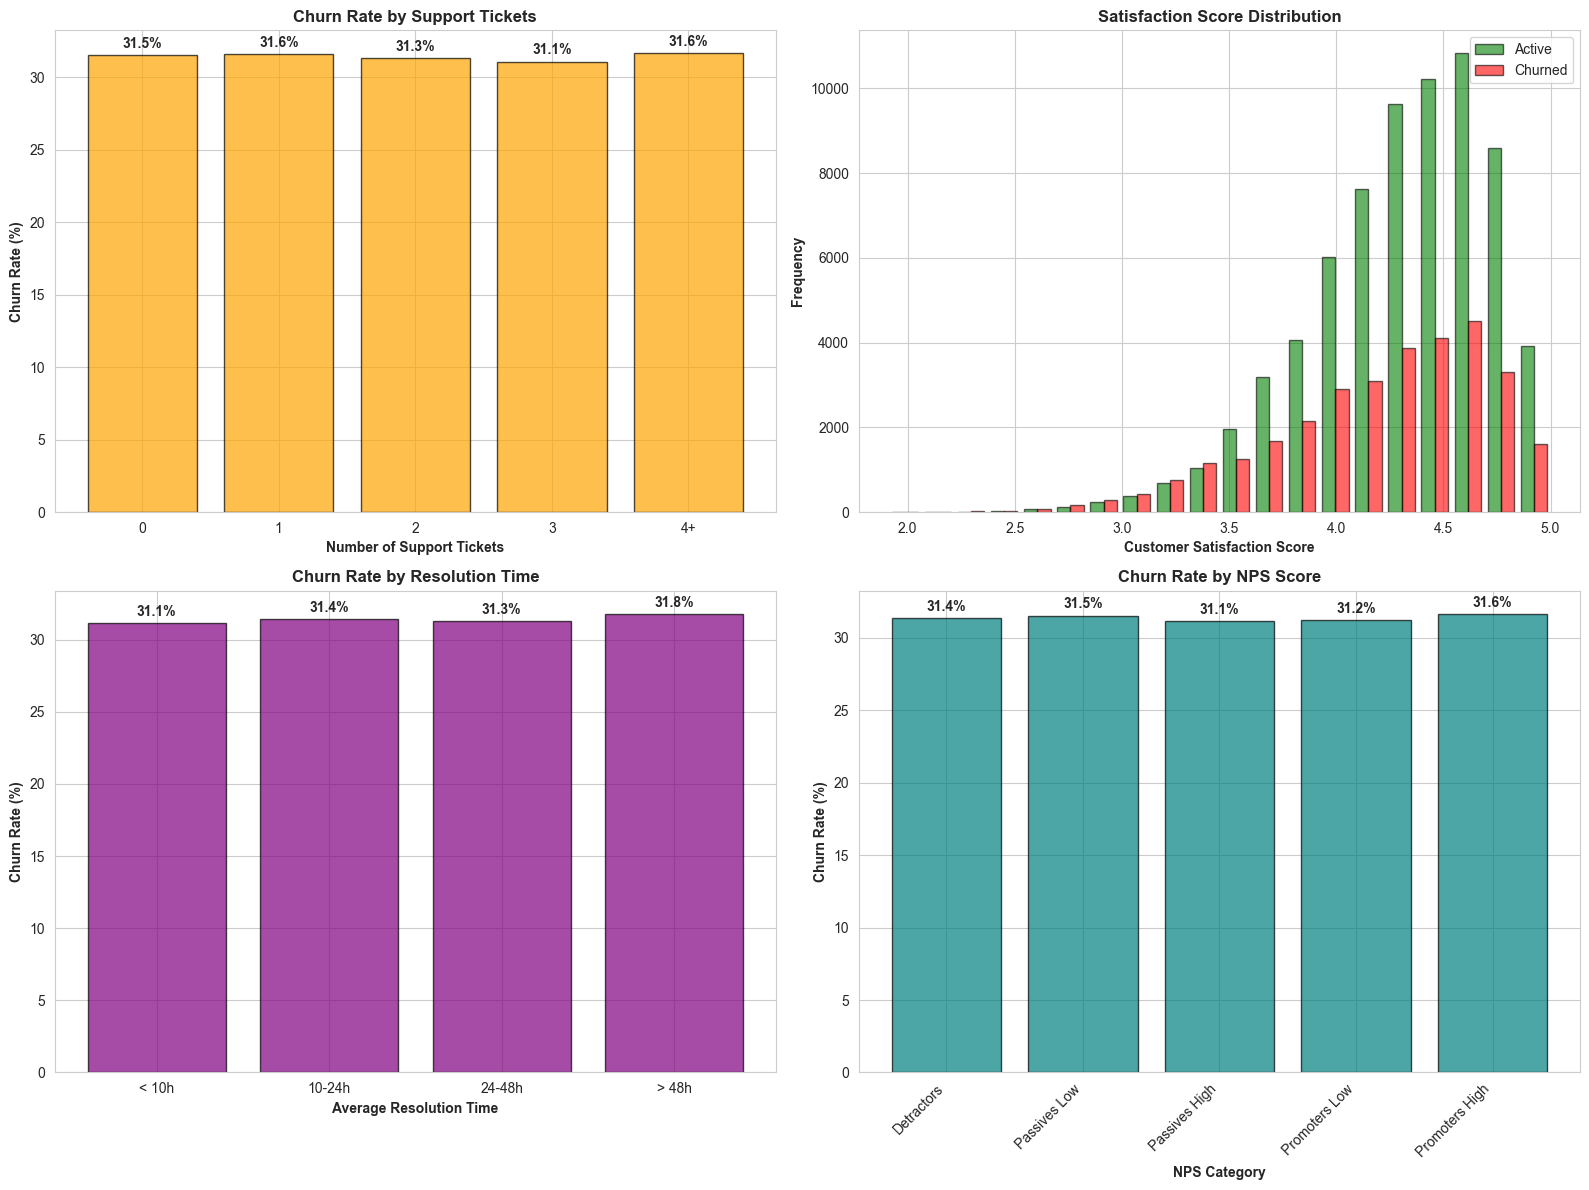


✓ Customer support analysis completed


In [107]:
# Visualize support impact
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Support tickets vs churn
ticket_bins = [0, 1, 2, 3, 5, float('inf')]
ticket_labels = ['0', '1', '2', '3', '4+']
df['ticket_category'] = pd.cut(df['num_support_tickets'], bins=ticket_bins, labels=ticket_labels)
ticket_churn = df.groupby('ticket_category')['churned'].mean() * 100
axes[0, 0].bar(range(len(ticket_churn)), ticket_churn.values, color='orange', edgecolor='black', alpha=0.7)
axes[0, 0].set_xticks(range(len(ticket_churn)))
axes[0, 0].set_xticklabels(ticket_churn.index)
axes[0, 0].set_ylabel('Churn Rate (%)', fontweight='bold')
axes[0, 0].set_xlabel('Number of Support Tickets', fontweight='bold')
axes[0, 0].set_title('Churn Rate by Support Tickets', fontsize=12, fontweight='bold')
for i, v in enumerate(ticket_churn.values):
    axes[0, 0].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

# 2. Satisfaction score distribution
axes[0, 1].hist([df[df['churned'] == 0]['customer_satisfaction_score'].dropna(),
                df[df['churned'] == 1]['customer_satisfaction_score'].dropna()],
               bins=20, label=['Active', 'Churned'], color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[0, 1].set_xlabel('Customer Satisfaction Score', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Satisfaction Score Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()

# 3. Resolution time impact
resolution_bins = [0, 10, 24, 48, float('inf')]
resolution_labels = ['< 10h', '10-24h', '24-48h', '> 48h']
df['resolution_category'] = pd.cut(df['avg_ticket_resolution_hours'], 
                                   bins=resolution_bins, labels=resolution_labels)
resolution_churn = df.groupby('resolution_category')['churned'].mean() * 100
axes[1, 0].bar(range(len(resolution_churn)), resolution_churn.values, 
              color='purple', edgecolor='black', alpha=0.7)
axes[1, 0].set_xticks(range(len(resolution_churn)))
axes[1, 0].set_xticklabels(resolution_churn.index)
axes[1, 0].set_ylabel('Churn Rate (%)', fontweight='bold')
axes[1, 0].set_xlabel('Average Resolution Time', fontweight='bold')
axes[1, 0].set_title('Churn Rate by Resolution Time', fontsize=12, fontweight='bold')
for i, v in enumerate(resolution_churn.values):
    axes[1, 0].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

# 4. NPS score impact
if 'nps_score' in df.columns:
    nps_bins = [-100, 0, 20, 40, 60, 100]
    nps_labels = ['Detractors', 'Passives Low', 'Passives High', 'Promoters Low', 'Promoters High']
    df['nps_category'] = pd.cut(df['nps_score'], bins=nps_bins, labels=nps_labels)
    nps_churn = df.groupby('nps_category')['churned'].mean() * 100
    axes[1, 1].bar(range(len(nps_churn)), nps_churn.values, color='teal', edgecolor='black', alpha=0.7)
    axes[1, 1].set_xticks(range(len(nps_churn)))
    axes[1, 1].set_xticklabels(nps_churn.index, rotation=45, ha='right')
    axes[1, 1].set_ylabel('Churn Rate (%)', fontweight='bold')
    axes[1, 1].set_xlabel('NPS Category', fontweight='bold')
    axes[1, 1].set_title('Churn Rate by NPS Score', fontsize=12, fontweight='bold')
    for i, v in enumerate(nps_churn.values):
        axes[1, 1].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Customer support analysis completed")

## 10. Regional Analysis


=== Regional Analysis ===
           Total_Customers  Churned  Churn_Rate  Avg_Monthly_Charges  \
region                                                                 
North                18056     5860        0.32               964.34   
Northeast            23129     7291        0.32               976.88   
South                13660     4308        0.32               980.21   
Central              35292    10891        0.31              1006.89   
East                  9863     3019        0.31              1010.59   

           Avg_Tenure  Avg_Satisfaction  Avg_Data_Usage  
region                                                   
North           28.34              4.27           66.08  
Northeast       28.47              4.28           67.86  
South           28.41              4.27           67.93  
Central         28.48              4.27           70.95  
East            28.30              4.27           71.05  


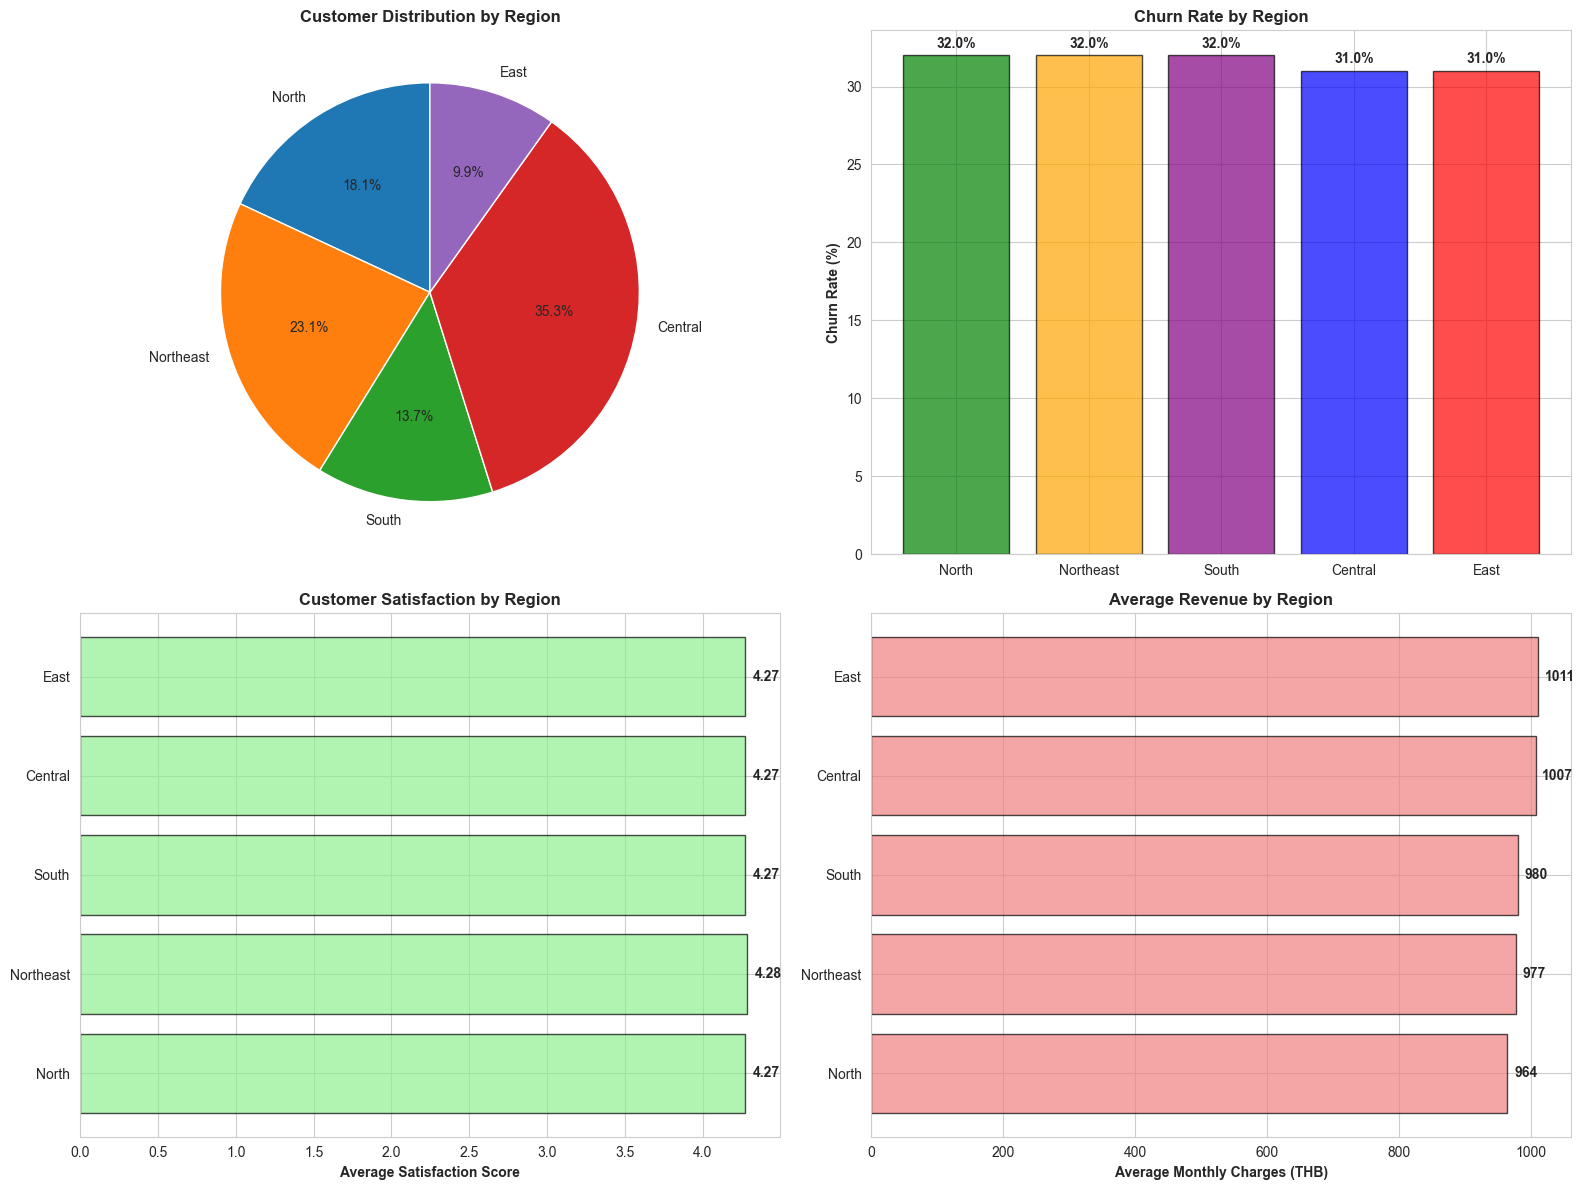


✓ Regional analysis completed


In [108]:
# Regional deep dive
if 'region' in df.columns:
    regional_analysis = df.groupby('region').agg({
        'customer_id': 'count',
        'churned': ['sum', 'mean'],
        'monthly_charges_thb': 'mean',
        'tenure_months': 'mean',
        'customer_satisfaction_score': 'mean',
        'data_usage_gb': 'mean'
    }).round(2)
    
    regional_analysis.columns = ['Total_Customers', 'Churned', 'Churn_Rate', 
                                 'Avg_Monthly_Charges', 'Avg_Tenure', 'Avg_Satisfaction', 'Avg_Data_Usage']
    regional_analysis = regional_analysis.sort_values('Churn_Rate', ascending=False)
    
    print("\n=== Regional Analysis ===")
    print(regional_analysis)
    
    # Visualize regional metrics
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Customer distribution by region
    axes[0, 0].pie(regional_analysis['Total_Customers'], labels=regional_analysis.index, 
                  autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Customer Distribution by Region', fontsize=12, fontweight='bold')
    
    # 2. Churn rate by region
    colors_map = {'Central': 'blue', 'Northeast': 'orange', 'North': 'green', 
                 'East': 'red', 'South': 'purple'}
    colors = [colors_map.get(region, 'gray') for region in regional_analysis.index]
    axes[0, 1].bar(range(len(regional_analysis)), regional_analysis['Churn_Rate'] * 100, 
                  color=colors, edgecolor='black', alpha=0.7)
    axes[0, 1].set_xticks(range(len(regional_analysis)))
    axes[0, 1].set_xticklabels(regional_analysis.index)
    axes[0, 1].set_ylabel('Churn Rate (%)', fontweight='bold')
    axes[0, 1].set_title('Churn Rate by Region', fontsize=12, fontweight='bold')
    for i, v in enumerate(regional_analysis['Churn_Rate'] * 100):
        axes[0, 1].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')
    
    # 3. Average satisfaction by region
    axes[1, 0].barh(range(len(regional_analysis)), regional_analysis['Avg_Satisfaction'], 
                   color='lightgreen', edgecolor='black', alpha=0.7)
    axes[1, 0].set_yticks(range(len(regional_analysis)))
    axes[1, 0].set_yticklabels(regional_analysis.index)
    axes[1, 0].set_xlabel('Average Satisfaction Score', fontweight='bold')
    axes[1, 0].set_title('Customer Satisfaction by Region', fontsize=12, fontweight='bold')
    for i, v in enumerate(regional_analysis['Avg_Satisfaction']):
        axes[1, 0].text(v + 0.05, i, f'{v:.2f}', va='center', fontweight='bold')
    
    # 4. Average revenue by region
    axes[1, 1].barh(range(len(regional_analysis)), regional_analysis['Avg_Monthly_Charges'], 
                   color='lightcoral', edgecolor='black', alpha=0.7)
    axes[1, 1].set_yticks(range(len(regional_analysis)))
    axes[1, 1].set_yticklabels(regional_analysis.index)
    axes[1, 1].set_xlabel('Average Monthly Charges (THB)', fontweight='bold')
    axes[1, 1].set_title('Average Revenue by Region', fontsize=12, fontweight='bold')
    for i, v in enumerate(regional_analysis['Avg_Monthly_Charges']):
        axes[1, 1].text(v + 10, i, f'{v:.0f}', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Regional analysis completed")

## 11. Risk Score Development

In [109]:
# Develop a simple churn risk score based on key factors
risk_score = pd.DataFrame()
risk_score['customer_id'] = df['customer_id']

# Normalize and score key risk factors (0-100 scale)
# Higher score = higher risk

# 1. Tenure risk (shorter tenure = higher risk)
risk_score['tenure_risk'] = (1 - (df['tenure_months'] / df['tenure_months'].max())) * 100

# 2. Satisfaction risk (lower satisfaction = higher risk)
risk_score['satisfaction_risk'] = (5 - df['customer_satisfaction_score']) / 4 * 100

# 3. Support ticket risk
risk_score['support_risk'] = (df['num_support_tickets'] / df['num_support_tickets'].max()) * 100

# 4. Payment issue risk
risk_score['payment_risk'] = ((df['payment_delay_days'] / df['payment_delay_days'].max()) * 50 + 
                              (df['num_payment_failures'] / df['num_payment_failures'].max()) * 50)

# 5. Contract risk (month-to-month = higher risk)
contract_risk_map = {'Prepaid': 80, 'Postpaid Monthly': 60, '1 Year': 30, '2 Year': 10}
risk_score['contract_risk'] = df['contract_type'].map(contract_risk_map).fillna(50)

# Calculate overall risk score (weighted average)
weights = {'tenure_risk': 0.25, 'satisfaction_risk': 0.30, 'support_risk': 0.15, 
          'payment_risk': 0.20, 'contract_risk': 0.10}

risk_score['overall_risk_score'] = (
    risk_score['tenure_risk'] * weights['tenure_risk'] +
    risk_score['satisfaction_risk'] * weights['satisfaction_risk'] +
    risk_score['support_risk'] * weights['support_risk'] +
    risk_score['payment_risk'] * weights['payment_risk'] +
    risk_score['contract_risk'] * weights['contract_risk']
)

# Categorize risk levels
risk_score['risk_category'] = pd.cut(risk_score['overall_risk_score'], 
                                     bins=[0, 25, 50, 75, 100],
                                     labels=['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk'])

# Merge with actual churn
risk_score['actual_churn'] = df['churned']

print("\n=== Risk Score Summary ===")
print(risk_score[['overall_risk_score', 'risk_category', 'actual_churn']].describe())

# Validate risk score
risk_validation = risk_score.groupby('risk_category')['actual_churn'].agg(['count', 'sum', 'mean']).reset_index()
risk_validation.columns = ['Risk_Category', 'Total', 'Churned', 'Actual_Churn_Rate']
risk_validation['Actual_Churn_Rate'] = (risk_validation['Actual_Churn_Rate'] * 100).round(2)

print("\n=== Risk Score Validation ===")
print(risk_validation.to_string(index=False))


=== Risk Score Summary ===
       overall_risk_score   actual_churn
count       100000.000000  100000.000000
mean            27.989342       0.313690
std              8.705581       0.463994
min              1.525000       0.000000
25%             21.391765       0.000000
50%             27.968176       0.000000
75%             34.489048       1.000000
max             60.931613       1.000000

=== Risk Score Validation ===
Risk_Category  Total  Churned  Actual_Churn_Rate
     Low Risk  38487     7674              19.94
  Medium Risk  61237    23486              38.35
    High Risk    276      209              75.72
Critical Risk      0        0                NaN


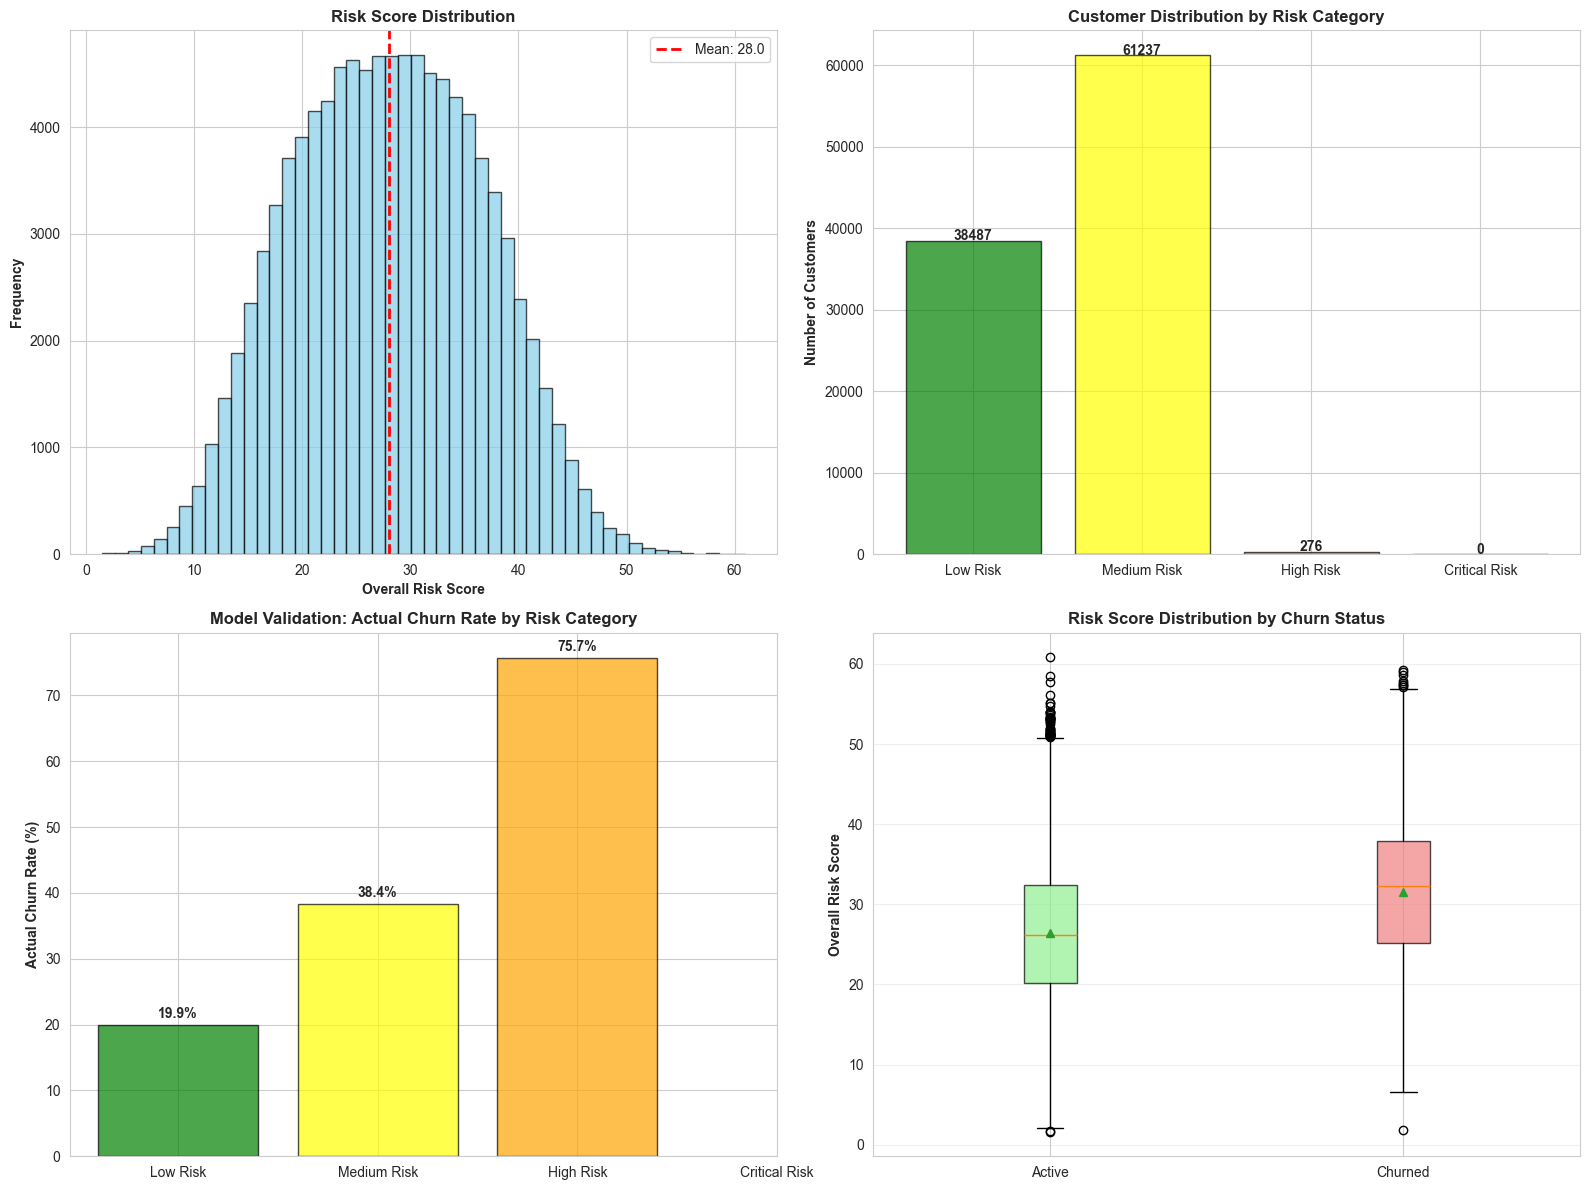


✓ Risk score analysis completed


In [110]:
# Visualize risk score distribution and validation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Risk score distribution
axes[0, 0].hist(risk_score['overall_risk_score'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(risk_score['overall_risk_score'].mean(), color='red', 
                  linestyle='--', linewidth=2, label=f'Mean: {risk_score["overall_risk_score"].mean():.1f}')
axes[0, 0].set_xlabel('Overall Risk Score', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Risk Score Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()

# 2. Risk category distribution
risk_dist = risk_score['risk_category'].value_counts().sort_index()
colors = ['green', 'yellow', 'orange', 'red']
axes[0, 1].bar(range(len(risk_dist)), risk_dist.values, color=colors, edgecolor='black', alpha=0.7)
axes[0, 1].set_xticks(range(len(risk_dist)))
axes[0, 1].set_xticklabels(risk_dist.index)
axes[0, 1].set_ylabel('Number of Customers', fontweight='bold')
axes[0, 1].set_title('Customer Distribution by Risk Category', fontsize=12, fontweight='bold')
for i, v in enumerate(risk_dist.values):
    axes[0, 1].text(i, v + 50, str(v), ha='center', fontweight='bold')

# 3. Actual churn rate by risk category
axes[1, 0].bar(range(len(risk_validation)), risk_validation['Actual_Churn_Rate'], 
              color=colors, edgecolor='black', alpha=0.7)
axes[1, 0].set_xticks(range(len(risk_validation)))
axes[1, 0].set_xticklabels(risk_validation['Risk_Category'])
axes[1, 0].set_ylabel('Actual Churn Rate (%)', fontweight='bold')
axes[1, 0].set_title('Model Validation: Actual Churn Rate by Risk Category', fontsize=12, fontweight='bold')
for i, v in enumerate(risk_validation['Actual_Churn_Rate']):
    axes[1, 0].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# 4. Risk score vs actual churn (box plot)
data_to_plot = [risk_score[risk_score['actual_churn'] == 0]['overall_risk_score'],
               risk_score[risk_score['actual_churn'] == 1]['overall_risk_score']]
bp = axes[1, 1].boxplot(data_to_plot, labels=['Active', 'Churned'], patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], ['lightgreen', 'lightcoral']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 1].set_ylabel('Overall Risk Score', fontweight='bold')
axes[1, 1].set_title('Risk Score Distribution by Churn Status', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Risk score analysis completed")

## 12. Key Insights and Recommendations

In [111]:
# Generate comprehensive insights summary
print("\n" + "="*80)
print("KEY INSIGHTS AND FINDINGS")
print("="*80)

overall_churn_rate = df['churned'].mean() * 100
print(f"\n1. OVERALL CHURN METRICS")
print(f"   - Overall Churn Rate: {overall_churn_rate:.2f}%")
print(f"   - Total Churned Customers: {df['churned'].sum():,}")
print(f"   - Average Customer Lifetime: {df['tenure_months'].mean():.1f} months")

print(f"\n2. TOP CHURN RISK FACTORS")
top_corr = churn_correlation.drop('churned').head(5)
for feature, corr in top_corr.items():
    print(f"   - {feature}: {corr:.3f}")

print(f"\n3. HIGHEST CHURN SEGMENTS")
print(f"   - Contract Type: {churn_analysis['contract_type'].iloc[0]['contract_type']} "
      f"({churn_analysis['contract_type'].iloc[0]['churn_rate_pct']:.1f}%)")
print(f"   - Tenure: New customers (0-6 months) show highest churn")
print(f"   - Service Usage: Customers with fewer services have higher churn")

print(f"\n4. CHURN REASONS BREAKDOWN")
for reason, count in churn_reasons.head(3).items():
    pct = (count / churn_reasons.sum() * 100)
    print(f"   - {reason}: {count} customers ({pct:.1f}%)")

print(f"\n5. CUSTOMER SATISFACTION")
avg_satisfaction_active = df[df['churned'] == 0]['customer_satisfaction_score'].mean()
avg_satisfaction_churned = df[df['churned'] == 1]['customer_satisfaction_score'].mean()
print(f"   - Active Customers: {avg_satisfaction_active:.2f}/5.0")
print(f"   - Churned Customers: {avg_satisfaction_churned:.2f}/5.0")
print(f"   - Difference: {avg_satisfaction_active - avg_satisfaction_churned:.2f} points")

print(f"\n6. REGIONAL INSIGHTS")
if 'region' in df.columns:
    highest_churn_region = regional_analysis.index[0]
    highest_churn_rate = regional_analysis['Churn_Rate'].iloc[0] * 100
    print(f"   - Highest Churn Region: {highest_churn_region} ({highest_churn_rate:.1f}%)")
    lowest_churn_region = regional_analysis.index[-1]
    lowest_churn_rate = regional_analysis['Churn_Rate'].iloc[-1] * 100
    print(f"   - Lowest Churn Region: {lowest_churn_region} ({lowest_churn_rate:.1f}%)")

print(f"\n7. REVENUE IMPACT")
avg_revenue_lost = df[df['churned'] == 1]['monthly_charges_thb'].sum()
print(f"   - Monthly Revenue Lost from Churn: {avg_revenue_lost:,.2f} THB")
avg_monthly_per_churned = df[df['churned'] == 1]['monthly_charges_thb'].mean()
print(f"   - Average Monthly Revenue per Churned Customer: {avg_monthly_per_churned:.2f} THB")

print("\n" + "="*80)
print("ACTIONABLE RECOMMENDATIONS")
print("="*80)
print("\n1. RETENTION STRATEGIES")
print("   - Focus on new customers (0-6 months tenure) with proactive onboarding")
print("   - Implement loyalty programs for long-term contract commitments")
print("   - Offer service bundles to increase customer stickiness")

print("\n2. PRICING & OFFERS")
print("   - Review pricing strategy for month-to-month contracts")
print("   - Create targeted retention offers for high-risk segments")
print("   - Implement win-back campaigns for competitor-lost customers")

print("\n3. CUSTOMER EXPERIENCE")
print("   - Improve ticket resolution time (correlated with churn)")
print("   - Enhance customer satisfaction through personalized support")
print("   - Monitor and act on customers with declining satisfaction scores")

print("\n4. PREDICTIVE ACTIONS")
print("   - Deploy the risk scoring model to identify at-risk customers")
print("   - Set up automated alerts for customers entering high-risk category")
print("   - Create targeted intervention workflows based on risk factors")

print("\n" + "="*80)
print("\n✓ Comprehensive EDA completed successfully!")
print(f"\nTotal visualizations: 10+ interactive charts generated")
print("="*80)


KEY INSIGHTS AND FINDINGS

1. OVERALL CHURN METRICS
   - Overall Churn Rate: 31.37%
   - Total Churned Customers: 31,369
   - Average Customer Lifetime: 28.4 months

2. TOP CHURN RISK FACTORS
   - price_increase_6months_thb: 0.072
   - postcode: 0.014
   - num_payment_failures: 0.013
   - last_login_days_ago: 0.009
   - payment_delay_days: 0.007

3. HIGHEST CHURN SEGMENTS
   - Contract Type: Prepaid (40.4%)
   - Tenure: New customers (0-6 months) show highest churn
   - Service Usage: Customers with fewer services have higher churn

4. CHURN REASONS BREAKDOWN
   - Price Too High: 9566 customers (30.5%)
   - Poor Signal Quality: 6256 customers (19.9%)
   - Competitor Offer: 5550 customers (17.7%)

5. CUSTOMER SATISFACTION
   - Active Customers: 4.30/5.0
   - Churned Customers: 4.20/5.0
   - Difference: 0.10 points

6. REGIONAL INSIGHTS
   - Highest Churn Region: North (32.0%)
   - Lowest Churn Region: East (31.0%)

7. REVENUE IMPACT
   - Monthly Revenue Lost from Churn: 29,572,700.00 T

## 13. Feature Engineering Opportunities

In [ ]:
# Identify potential features for modeling
# we can create a power bi on this, 
print("\n=== RECOMMENDED ENGINEERED FEATURES FOR MODELING ===")
print("\n1. Customer Lifetime Value (CLV) Proxy")
print("   - tenure_months * monthly_charges_thb")

print("\n2. Service Adoption Score")
print("   - Total number of additional services subscribed")

print("\n3. Customer Health Score")
print("   - Combination of satisfaction, NPS, and support metrics")

print("\n4. Payment Reliability Score")
print("   - Based on payment delays and failures")

print("\n5. Engagement Metrics")
print("   - data_usage_gb / average for plan type")
print("   - Recency of last login")

print("\n6. Price Sensitivity Indicators")
print("   - Response to price increases")
print("   - Discount dependency")

print("\n7. Support Quality Metrics")
print("   - Average resolution time vs benchmark")
print("   - Tickets per month rate")

print("\n8. Contract Risk Factors")
print("   - Days to contract end")
print("   - Number of plan downgrades")

print("\n9. Competitive Threat Indicators")
print("   - Region-specific competitive pressure")
print("   - Historical competitor switch rates")

print("\n10. Temporal Features")
print("   - Account age cohort")
print("   - Seasonality effects")
print("   - Recent behavior changes (trend features)")

print("\n" + "="*80)
print("Next Steps:")
print("1. Feature engineering based on insights above")
print("2. Feature selection using statistical tests and ML methods")
print("3. Develop survival analysis models")
print("4. Build churn prediction models (classification)")
print("5. Create customer retention strategies")
print("="*80)


=== RECOMMENDED ENGINEERED FEATURES FOR MODELING ===

1. Customer Lifetime Value (CLV) Proxy
   - tenure_months * monthly_charges_thb

2. Service Adoption Score
   - Total number of additional services subscribed

3. Customer Health Score
   - Combination of satisfaction, NPS, and support metrics

4. Payment Reliability Score
   - Based on payment delays and failures

5. Engagement Metrics
   - data_usage_gb / average for plan type
   - Recency of last login

6. Price Sensitivity Indicators
   - Response to price increases
   - Discount dependency

7. Support Quality Metrics
   - Average resolution time vs benchmark
   - Tickets per month rate

8. Contract Risk Factors
   - Days to contract end
   - Number of plan downgrades

9. Competitive Threat Indicators
   - Region-specific competitive pressure
   - Historical competitor switch rates

10. Temporal Features
   - Account age cohort
   - Seasonality effects
   - Recent behavior changes (trend features)

Next Steps:
1. Feature engine